In [16]:
!pip install SciencePlots


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import os, shutil
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

# Concatena todos os JSONs em um
Sinceramente, não aconselho fazer isso, aĺém de demorado o Fiftyone apresenta limitações com muitos dados tornando-o muito pesado e consumindo muuuuita memória RAM. Eu não consegui unificar todos e acabei trabalhando com eles de forma individual mesmo.

In [ ]:
import fiftyone as fo

In [ ]:
path_datasets = 'tmp/dataset'
dataset = None
for filename in os.listdir(path_datasets):
    if filename.endswith('.json'):
        print(f'Processing {filename}...')
        if dataset is None:
            dataset = fo.Dataset.from_json(f'{path_datasets}/{filename}')
        else:
            dataset_new = fo.Dataset.from_json(f'{path_datasets}/{filename}')
            dataset_new_temp = dataset_new.exclude_fields('ground_truth')
            dataset.merge_samples(dataset_new_temp)
            
dataset.write_json(f'{path_datasets}/all_results.json')

# Realizar inferências e visualziar no FiftyOne
Pode ser realizado inferências isoladas para avaliar visualmente os resultados dos modelos treinados.

In [ ]:
import fiftyone as fo
import fiftyone.utils.ultralytics as fou

from ultralytics import YOLO

In [ ]:
model = YOLO('tmp/dataset/yolo/yolo-0_15-100-100-100/bbox_larger/runs/train/weights/best.pt')

In [ ]:
# Dataset splits to load in FiftyOne
splits = ['test']
# Folder to annotation
path_dataset = 'tmp/dataset/yolo/yolo-0_5-100-100-100/bbox_official'
# Folder to images
path_images = 'tmp/dataset/images'

In [ ]:
dataset = fo.Dataset()

for split in splits:
    # Copy images to the same folder as labels (YOLOv5 format)
    for filename in os.listdir(f'{path_dataset}/{split}/labels'):
        Path(f'{path_dataset}/{split}/images').mkdir(parents=True, exist_ok=True)
        shutil.copy(f'{path_images}/{split}/{filename[:-3]}png', f'{path_dataset}/{split}/images')

    # Load imagens in FiftyOne
    dataset.add_dir(
        dataset_dir=path_dataset,
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
    )

In [ ]:
default_classes = dataset.default_classes

# YOLO model inference and store results in FiftyOne
for sample in dataset.iter_samples(progress=True):
    result = model(sample['filepath'], verbose=False)
    sample['YOLOv8'] = fou.to_detections(result[0])
    sample.save()

In [ ]:
# Optional: Evaluate results
results = dataset.evaluate_detections(
    pred_field='YOLOv8',
    gt_field='ground_truth',
    eval_key='eval',  # Key to save result (if ommit, not save)
    compute_mAP=True,  # 0.5, .05, .95 (COCO metrics)
    use_boxes=True
)

In [ ]:
fo.launch_app(dataset)

# Análise dos resultados
Partiu analisar os resultados de todos os treinamentos e testes realizados!

Não deixei todas as análises e gráficos que plotei neste Jupyter para não poluí-lo muito, optei por manter somente os que achei mais relevantes.

In [3]:
df = pd.read_csv('all_results.csv', index_col=0)

In [4]:
df.keys()

Index(['type', 'margin', 'right_class', 'all_class', 'size_dataset',
       'train/bbox_loss', 'train/cls_loss', 'train/dfl_loss',
       'train/num_epochs', 'train/mean_time_epoch', 'train/total_time',
       'val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95',
       'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'test/accuracy',
       'test/precision', 'test/recall', 'test/fscore', 'test/mAP50-95',
       'test/precision-circle', 'test/recall-circle', 'test/fscore-circle',
       'test/precision-rect', 'test/recall-rect', 'test/fscore-rect',
       'test/mean_confidence', 'test/mean_IoU', 'dataset/mean_IoU_train',
       'dataset/mean_IoU_val', 'dataset/missing_bbox_train',
       'dataset/missing_bbox_val', 'dataset/wrong_cls_train',
       'dataset/wrong_cls_val'],
      dtype='object')

Apenas para ajudar a diferenciar os casos "officials" (que possuem anotações perfeitas) será alterado a margim para "0_0" em vez do valor atual (que não está totalmente correto hehe)

In [5]:
df.loc[df['type'] == 'bbox_official', 'margin'] = '0_0'

### Avaliar margin sem outros tipos de problemas

![inference-0_5-larger_smaller_inference.png](attachment:8f70561a-ba9c-4a3f-8ee2-1320ff0f023a.png "Resultado de um modelo larger_smaller sem outros tipos de problemas")

[img1] Resultado de um modelo larger_smaller sem outros tipos de problemas

![inference-0_15-larger-100-100.png](attachment:2489cdfa-3897-48ba-a2bb-aca887efe85d.png "Resultado de um modelo com margem de 0_15 larger sem outros tipos de problemas")

[img2] Resultado de um modelo com margem de 0_15 larger sem outros tipos de problemas


A anotação perfeita teve o melhor resultado, tendo acurácias de praticamente 100% e se tratando da média da confiança, o modelo ficou extremamente confiente dos resultados dado, tendo inclusive um IoU próximo do perfeito. Segue alguns pensamentos baseados nos resultados:
- Quanto maior a margem, menor a confinaça do modelo -> mostrando que o modelo não consegue entender completamente os objetos;
- Quanto maior a margem, menor o recall -> mostrando que o modelo apresenta maiores dificuldades para localizar os objetos. Isso aconteceu devido a confiança ter ficado muito baixa, o que desonsiderou diversas inferências;
- Quantro maior a margem, diminui significativamente a acurácia -> mostrando que o resultado do modelo pode piorar exponencialmente conforme o bbox é maior ou menor que o tamanho correto, também precisamos levar em consideração que muitas detecções, sim, foram realizadas corretamente, porém por ter um IoU baixo em relação ao valor real, principalmente os casos com 0_15 de margem (exemplo na imagem 2) isso acabou resultado em uma penalidade na precisão porque não foi considerado uma detecção correta;
- É preferível ter anotações dos bboxs menores do que maiores e mistas -> com bbox maior gera mais erros de recall e mistas mais erros de precision, porém com bbox menor, ambos valores ficaram equilibrados e interessantes. Talvez por ter reduzido ruídos adicionando o fundo da imagem e até mesmo objetos vizinhos ao aumentar o tamanho do bbox. Inclusive entre todas as abordagens, eles apresentou o melhor resultado em confiança, mesmo tenho um IoU menor;
- O modelo conseguiu entende melhor onde criar os bboxs tendo anotação mista (exemplo de resultado na imagem 1) -> por termos ambos os exemplos o modelo conseguiu entender o que existe em comum entre as anotações mistas e criar um bbox mais próximo do perfeito. Mas ao mesmo tempo precisamos ter em mentede que na criação do cenário existia a mesma probabilidade de criar bbox maiores e menores, inclusive com a mesma intensidade. O modelo pode ter apenas aprendido a ficar no meio termo. [talvez se tivessemos probabilidades diferentes (o que se assemelha mais ao mundo real) para bbox maior e menor o resultado não seria tão bom assim].
- Dataset de validação mal anotado pode gerar resultados bem enganativos -> no caso do bbox_larger com margem 0_10, tivemos tanto precision quanto recall de 99% na validação, mas em teste (produção) os resultados cariram drásticamente. [talvez se tivessemos um dataset de validação muito bem anotado iriamos conseguir selecionar melhor os nossos modelos... mesmo que os dados de treinamento não estivessem perfeitos?];

**Em resumo:** Anotações perfeitas são preferíveis, mas sabemos que a imprecissão do ser humano dificulta e praticamente inviabiliza que isso aconteça. Infelizmente isso acaba resultado em uma queda até que significante nos resultados, principalmente na confiança do modelo. Mas na dúvida, parece ser preferível ter um bbox levemente menor do que maior, podendo indicar que os ruídos adicionados ao fazer o bbox maior podem dificultar no entendimento do modelo.
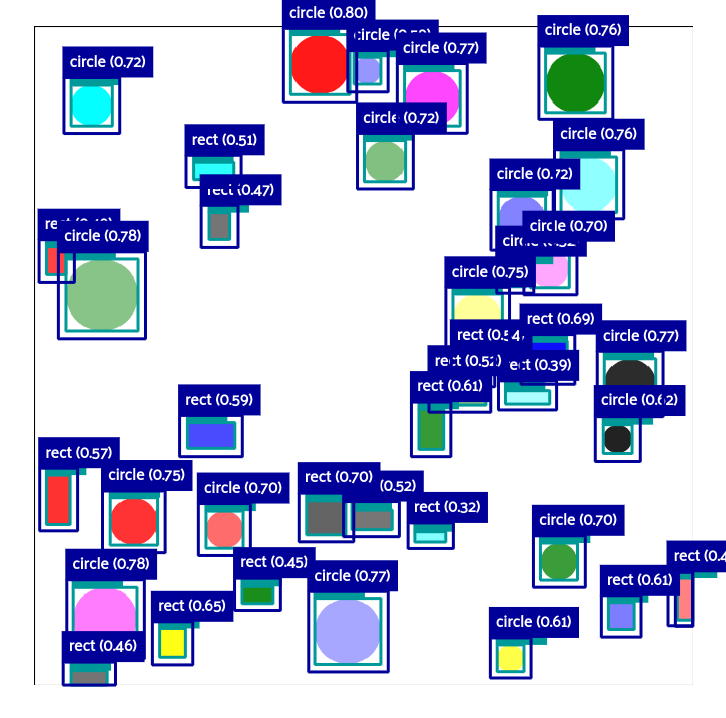
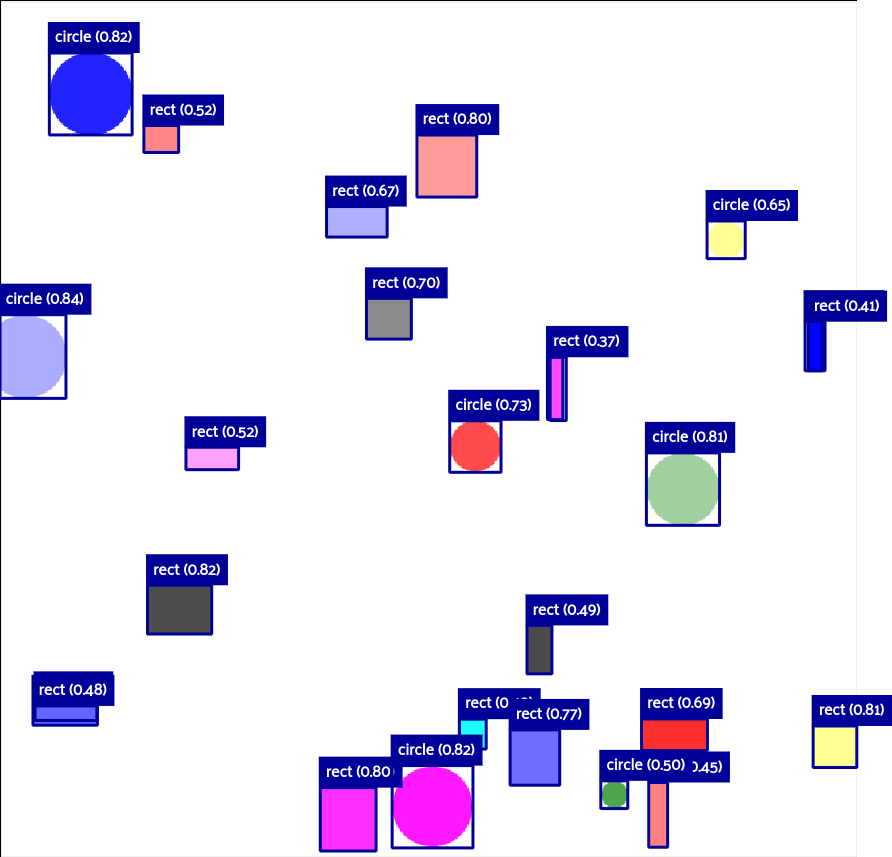

In [6]:
get = ['margin', 'val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95',
       'test/accuracy', 'test/precision', 'test/recall', 'test/fscore',
       'test/mAP50-95', 'test/mean_confidence', 'test/mean_IoU']

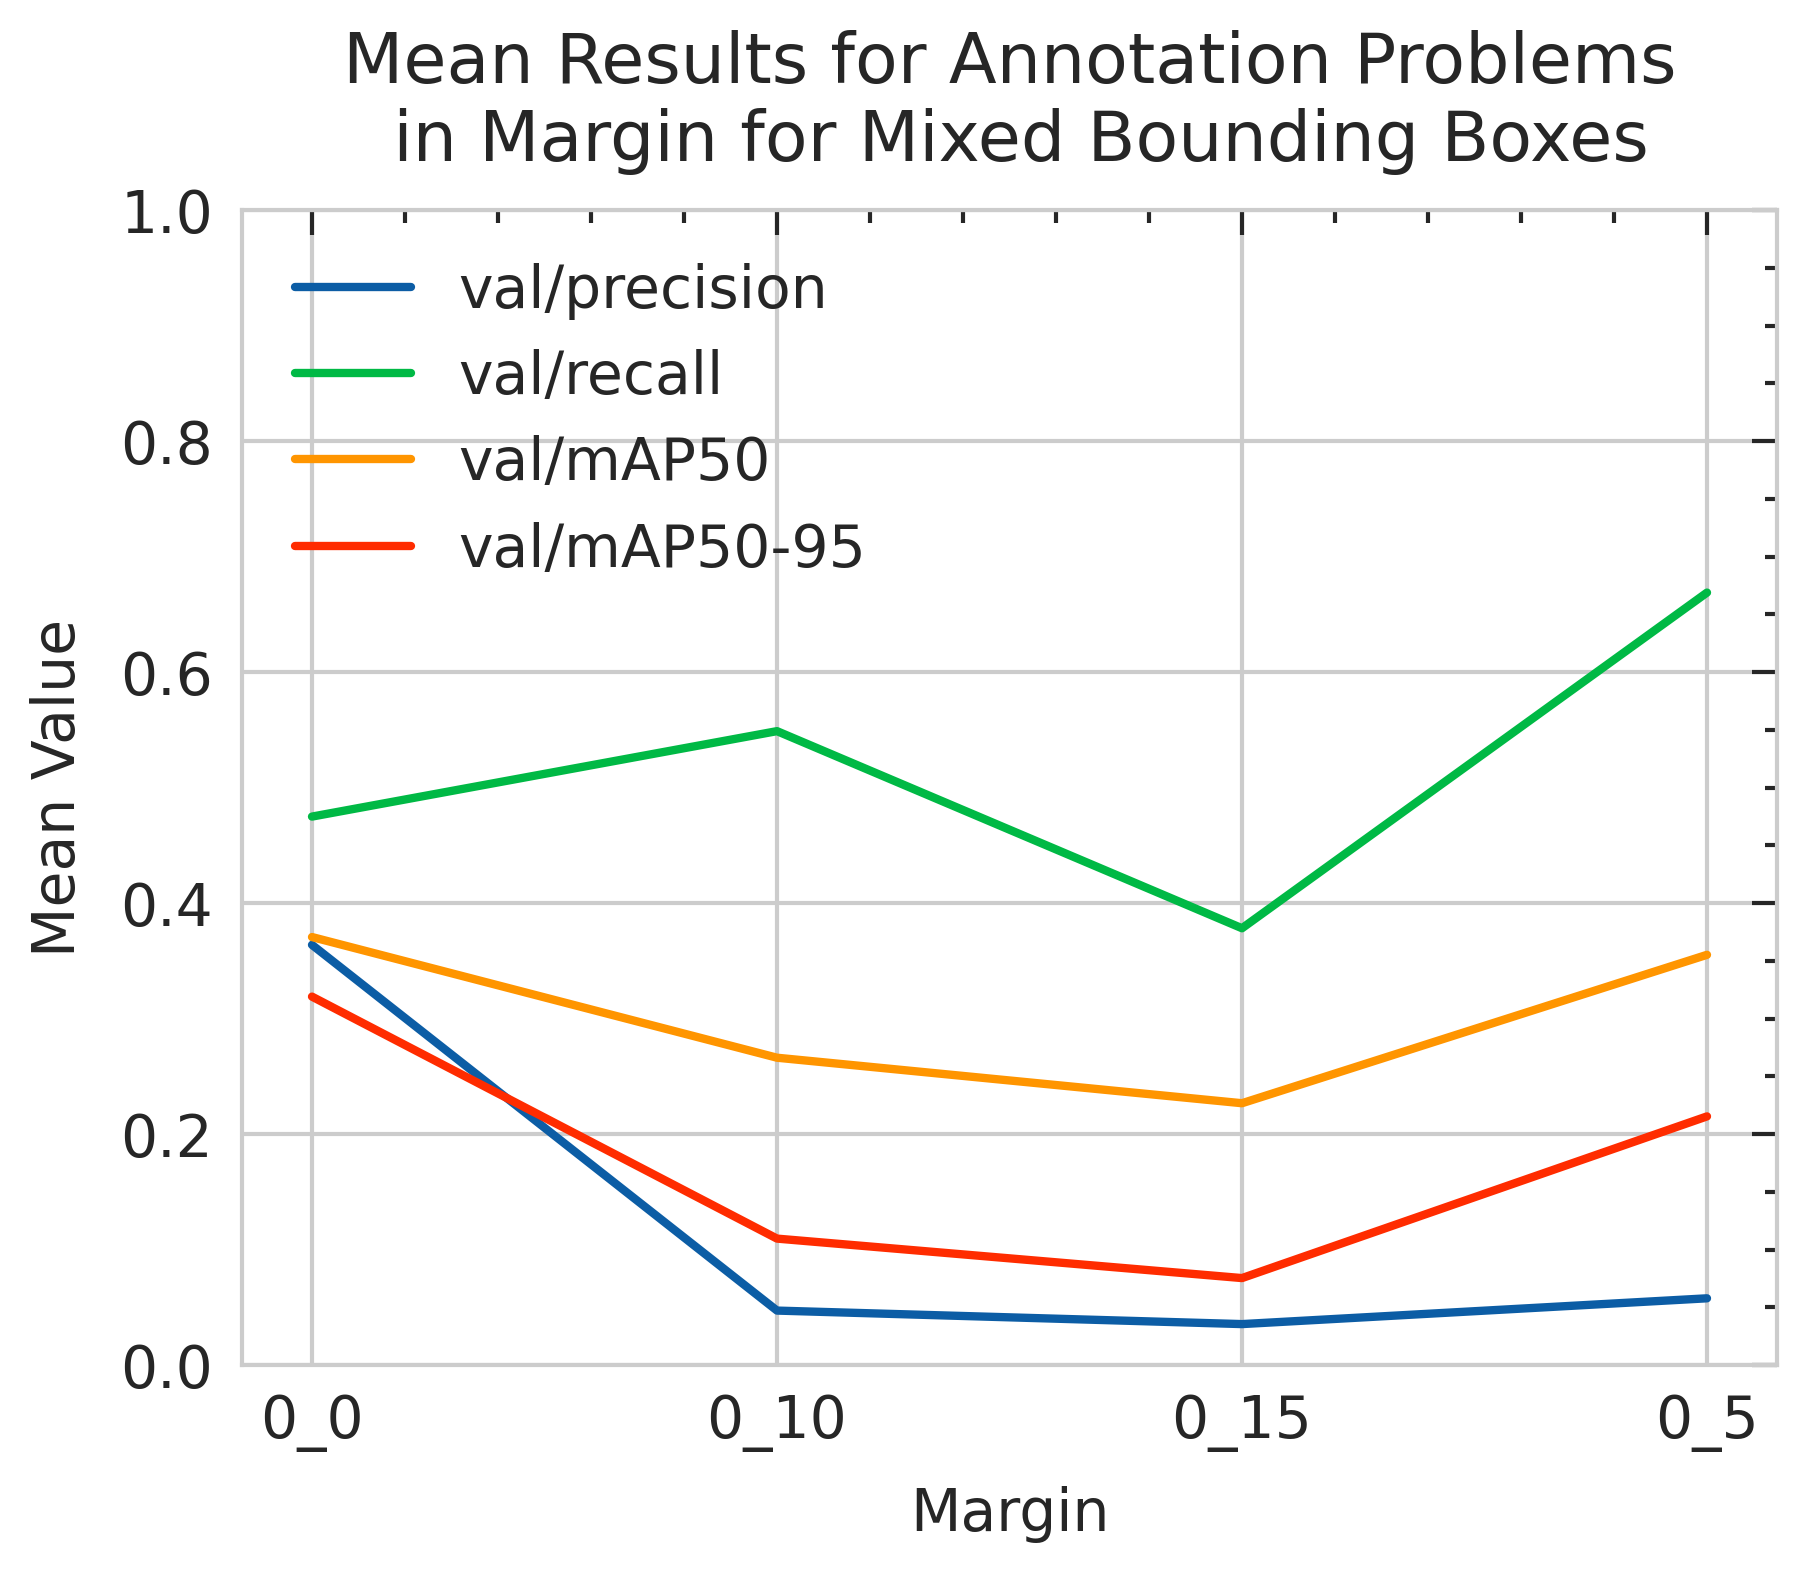

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponha que você já tenha df_filtered e get definidos

# Média dos resultados para problemas de anotação apenas na margem para bounding boxes mistos
df_filtered = df[((df['type'] == 'bbox_larger_smaller') | (df['type'] == 'bbox_official')) & (df['right_class'] == 100) & (df['all_class'] == 100)]

# Calcular a média dos resultados agrupados por 'margin'
mean_values = df_filtered[get].groupby('margin').mean()

# Extrair as colunas que serão usadas no gráfico (por exemplo, 'precision' e 'recall')
columns_to_plot = ['val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95']

# Configure o estilo para 'science' e 'nature'
plt.style.use(['science', 'nature'])

# Desativar o uso de LaTeX para processamento de texto
plt.rcParams.update({'text.usetex': False})

# Plotar cada coluna em um gráfico separado
for column in columns_to_plot:
    plt.plot(mean_values.index, mean_values[column], label=column)

# Adicionar rótulos aos eixos x e y
plt.xlabel('Margin')
plt.ylabel('Mean Value')

# Limitar o eixo y de 0 até 1.0
plt.ylim(0, 1.0)

# Adicionar título ao gráfico
plt.title('Mean Results for Annotation Problems\n in Margin for Mixed Bounding Boxes')

# Adicionar legenda no melhor local possível
plt.legend(loc='best')

# Salvar o gráfico em PNG com 600 DPI
plt.savefig('C:/Users/cdsfj/Documents/GitHub/mestrado_ppgcc/test_segmentation/figures/mean_results_1.png', dpi=600)

# Mostrar o gráfico
plt.show()

In [7]:
# Média dos resultados para problemas de anotação apenas na margem para bounding boxes mistos
df_filtered = df[((df['type'] == 'bbox_larger_smaller') | (df['type'] == 'bbox_official')) & (df['right_class'] == 100) & (df['all_class'] == 100)]
df_filtered[get].groupby('margin').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
margin,,,,,,,,,,,
0_0,0.363780,0.474823,0.370543,0.318960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_10,0.047127,0.548810,0.266063,0.109447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_15,0.035433,0.378153,0.226660,0.075270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_5,0.057753,0.668773,0.355153,0.215263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
# Média dos resultados para problemas de anotação apenas na margem para bounding boxes maiores
df_filtered = df[((df['type'] == 'bbox_larger') | (df['type'] == 'bbox_official')) & (df['right_class'] == 100) & (df['all_class'] == 100)]
df_filtered[get].groupby('margin').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
margin,,,,,,,,,,,
0_0,0.999913,0.999930,0.995000,0.994460,0.999780,0.999816,0.999963,0.999890,0.993866,0.978332,0.987694
0_10,0.995693,0.995750,0.994060,0.621520,0.629750,0.869409,0.717218,0.769986,0.259715,0.654937,0.664579
0_15,0.974230,0.981613,0.988690,0.516890,0.320963,0.479033,0.492503,0.485603,0.127420,0.621383,0.611747
0_5,0.999640,0.999693,0.994973,0.783573,0.920118,0.999573,0.920525,0.954695,0.580369,0.711410,0.798105


In [8]:
# Média dos resultados para problemas de anotação apenas na margem para bounding boxes menores
df_filtered = df[((df['type'] == 'bbox_smaller') | (df['type'] == 'bbox_official')) & (df['right_class'] == 100) & (df['all_class'] == 100)]
df_filtered[get].groupby('margin').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
margin,,,,,,,,,,,
0_0,0.999913,0.999930,0.995000,0.994460,0.999780,0.999816,0.999963,0.999890,0.993866,0.978332,0.987694
0_10,0.869947,0.707847,0.780487,0.378567,0.546786,0.771191,0.652952,0.706642,0.222210,0.588207,0.653779
0_15,0.655480,0.403260,0.465087,0.182667,0.360905,0.943247,0.368646,0.529835,0.086641,0.509785,0.598118
0_5,0.983833,0.980397,0.987063,0.709480,0.984448,0.989151,0.995202,0.992159,0.580320,0.770583,0.771330


#### Quantidade de dados diferente
Está é uma métrica que não se mostrou muito representativo com mundo real, já que a complexidade do ambiente é extremamente simples, pois os fundo nunca muda e os objetos são sempre praticamente iguais, mudando apenas suas localizações. Então foi utilizado o pensamento de ter treinado por mais épocas e não necessáriamente adicionar mais dados. Segue alguns pensamentos baseados nos resultados:

- Dados com anotações perfeitas ou próximas a isso não mostraram mudanças significativas -> em pouco tempo o modelo já atingiu o seu limite no aprendizado, não sendo necessário longos tempos de treinamento;
- Dados com anotações ruins tiveram uma leve melhora com treinamentos maiores -> tempo maior de treinamento pode parcialmente ajudar os modelos com anotações ruins a melhorarem, mas nada muito significativo.

**Em resumo:** Treinar por mais tempo ou adicionar mais imagens com ambientes praticamente iguais, não irá fazer milagre caso os bboxs estejam com anotaçãoes imprecisas. Não tendo impacto significantivo em nenhuma das métricas.

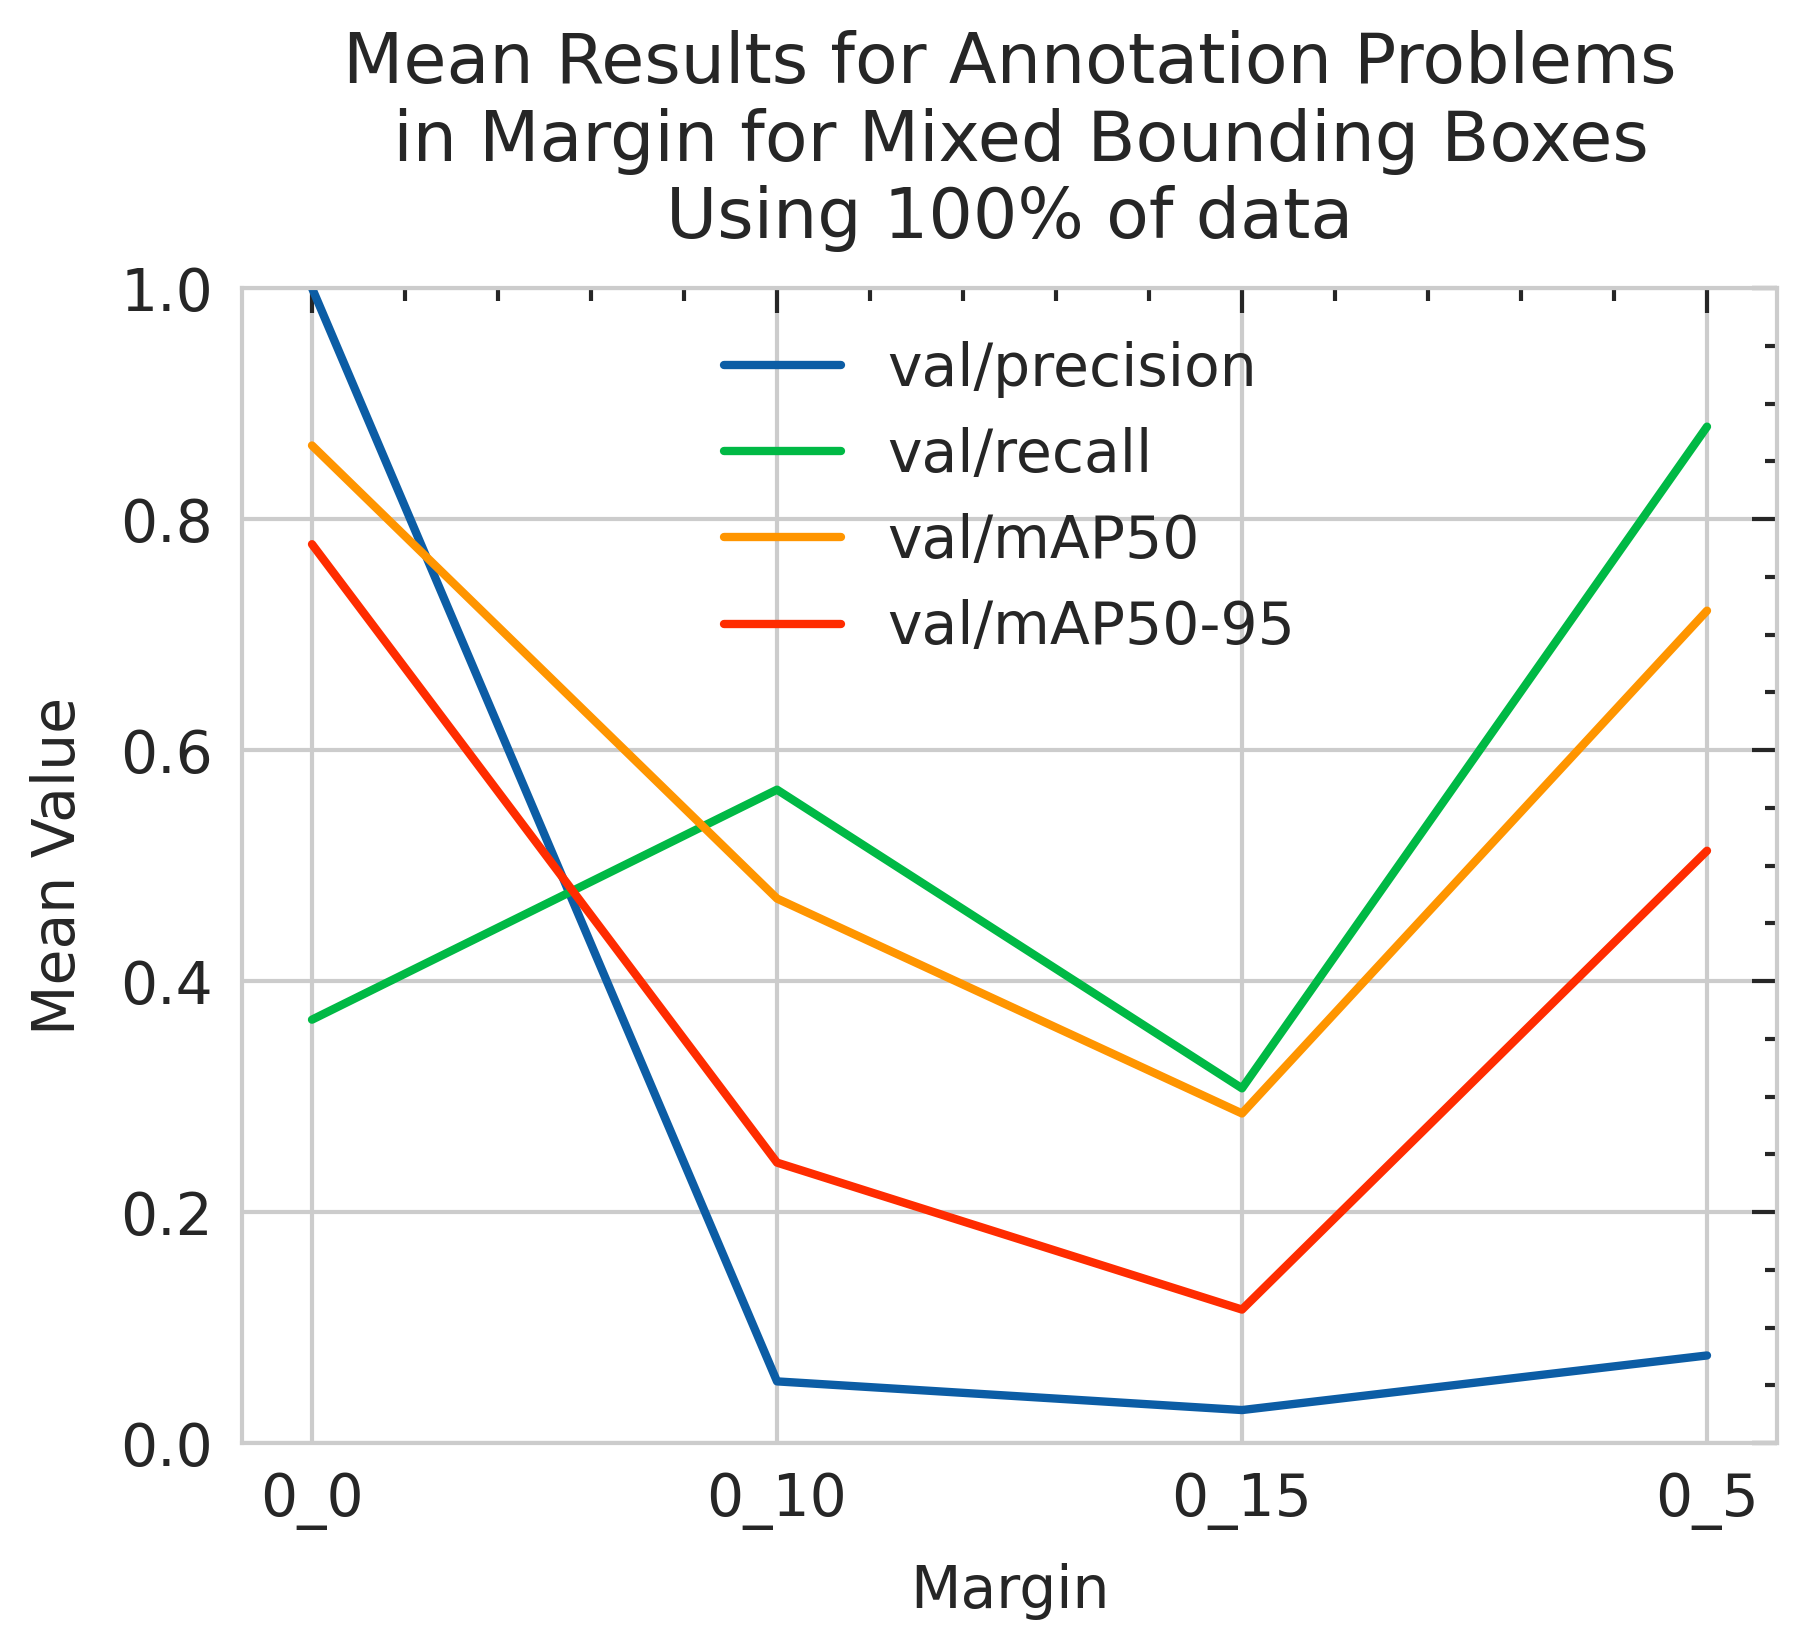

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# 100% dos dados de treinamento - 6000 imagens
df_filtered = df[((df['type'] == 'bbox_smaller') | (df['type'] == 'bbox_official')) & (df['right_class'] == 100) & (df['all_class'] == 100) & (df['size_dataset'] == 100)]
mean_values = df_filtered[get].groupby('margin').mean()

# Extrair as colunas que serão usadas no gráfico (por exemplo, 'precision' e 'recall')
columns_to_plot = ['val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95']

# Configure o estilo para 'science' e 'nature'
plt.style.use(['science', 'nature'])

# Desativar o uso de LaTeX para processamento de texto
plt.rcParams.update({'text.usetex': False})

# Plotar cada coluna em um gráfico separado
for column in columns_to_plot:
    plt.plot(mean_values.index, mean_values[column], label=column)

# Adicionar rótulos aos eixos x e y
plt.xlabel('Margin')
plt.ylabel('Mean Value')

# Limitar o eixo y de 0 até 1.0
plt.ylim(0, 1.0)

# Adicionar título ao gráfico
plt.title('Mean Results for Annotation Problems\n in Margin for Mixed Bounding Boxes\nUsing 100% of data')

# Adicionar legenda no melhor local possível
plt.legend(loc='best')

# Salvar o gráfico em PNG com 600 DPI
plt.savefig('C:/Users/cdsfj/Documents/GitHub/mestrado_ppgcc/test_segmentation/figures/mean_results_2.png', dpi=600)

# Mostrar o gráfico
plt.show()

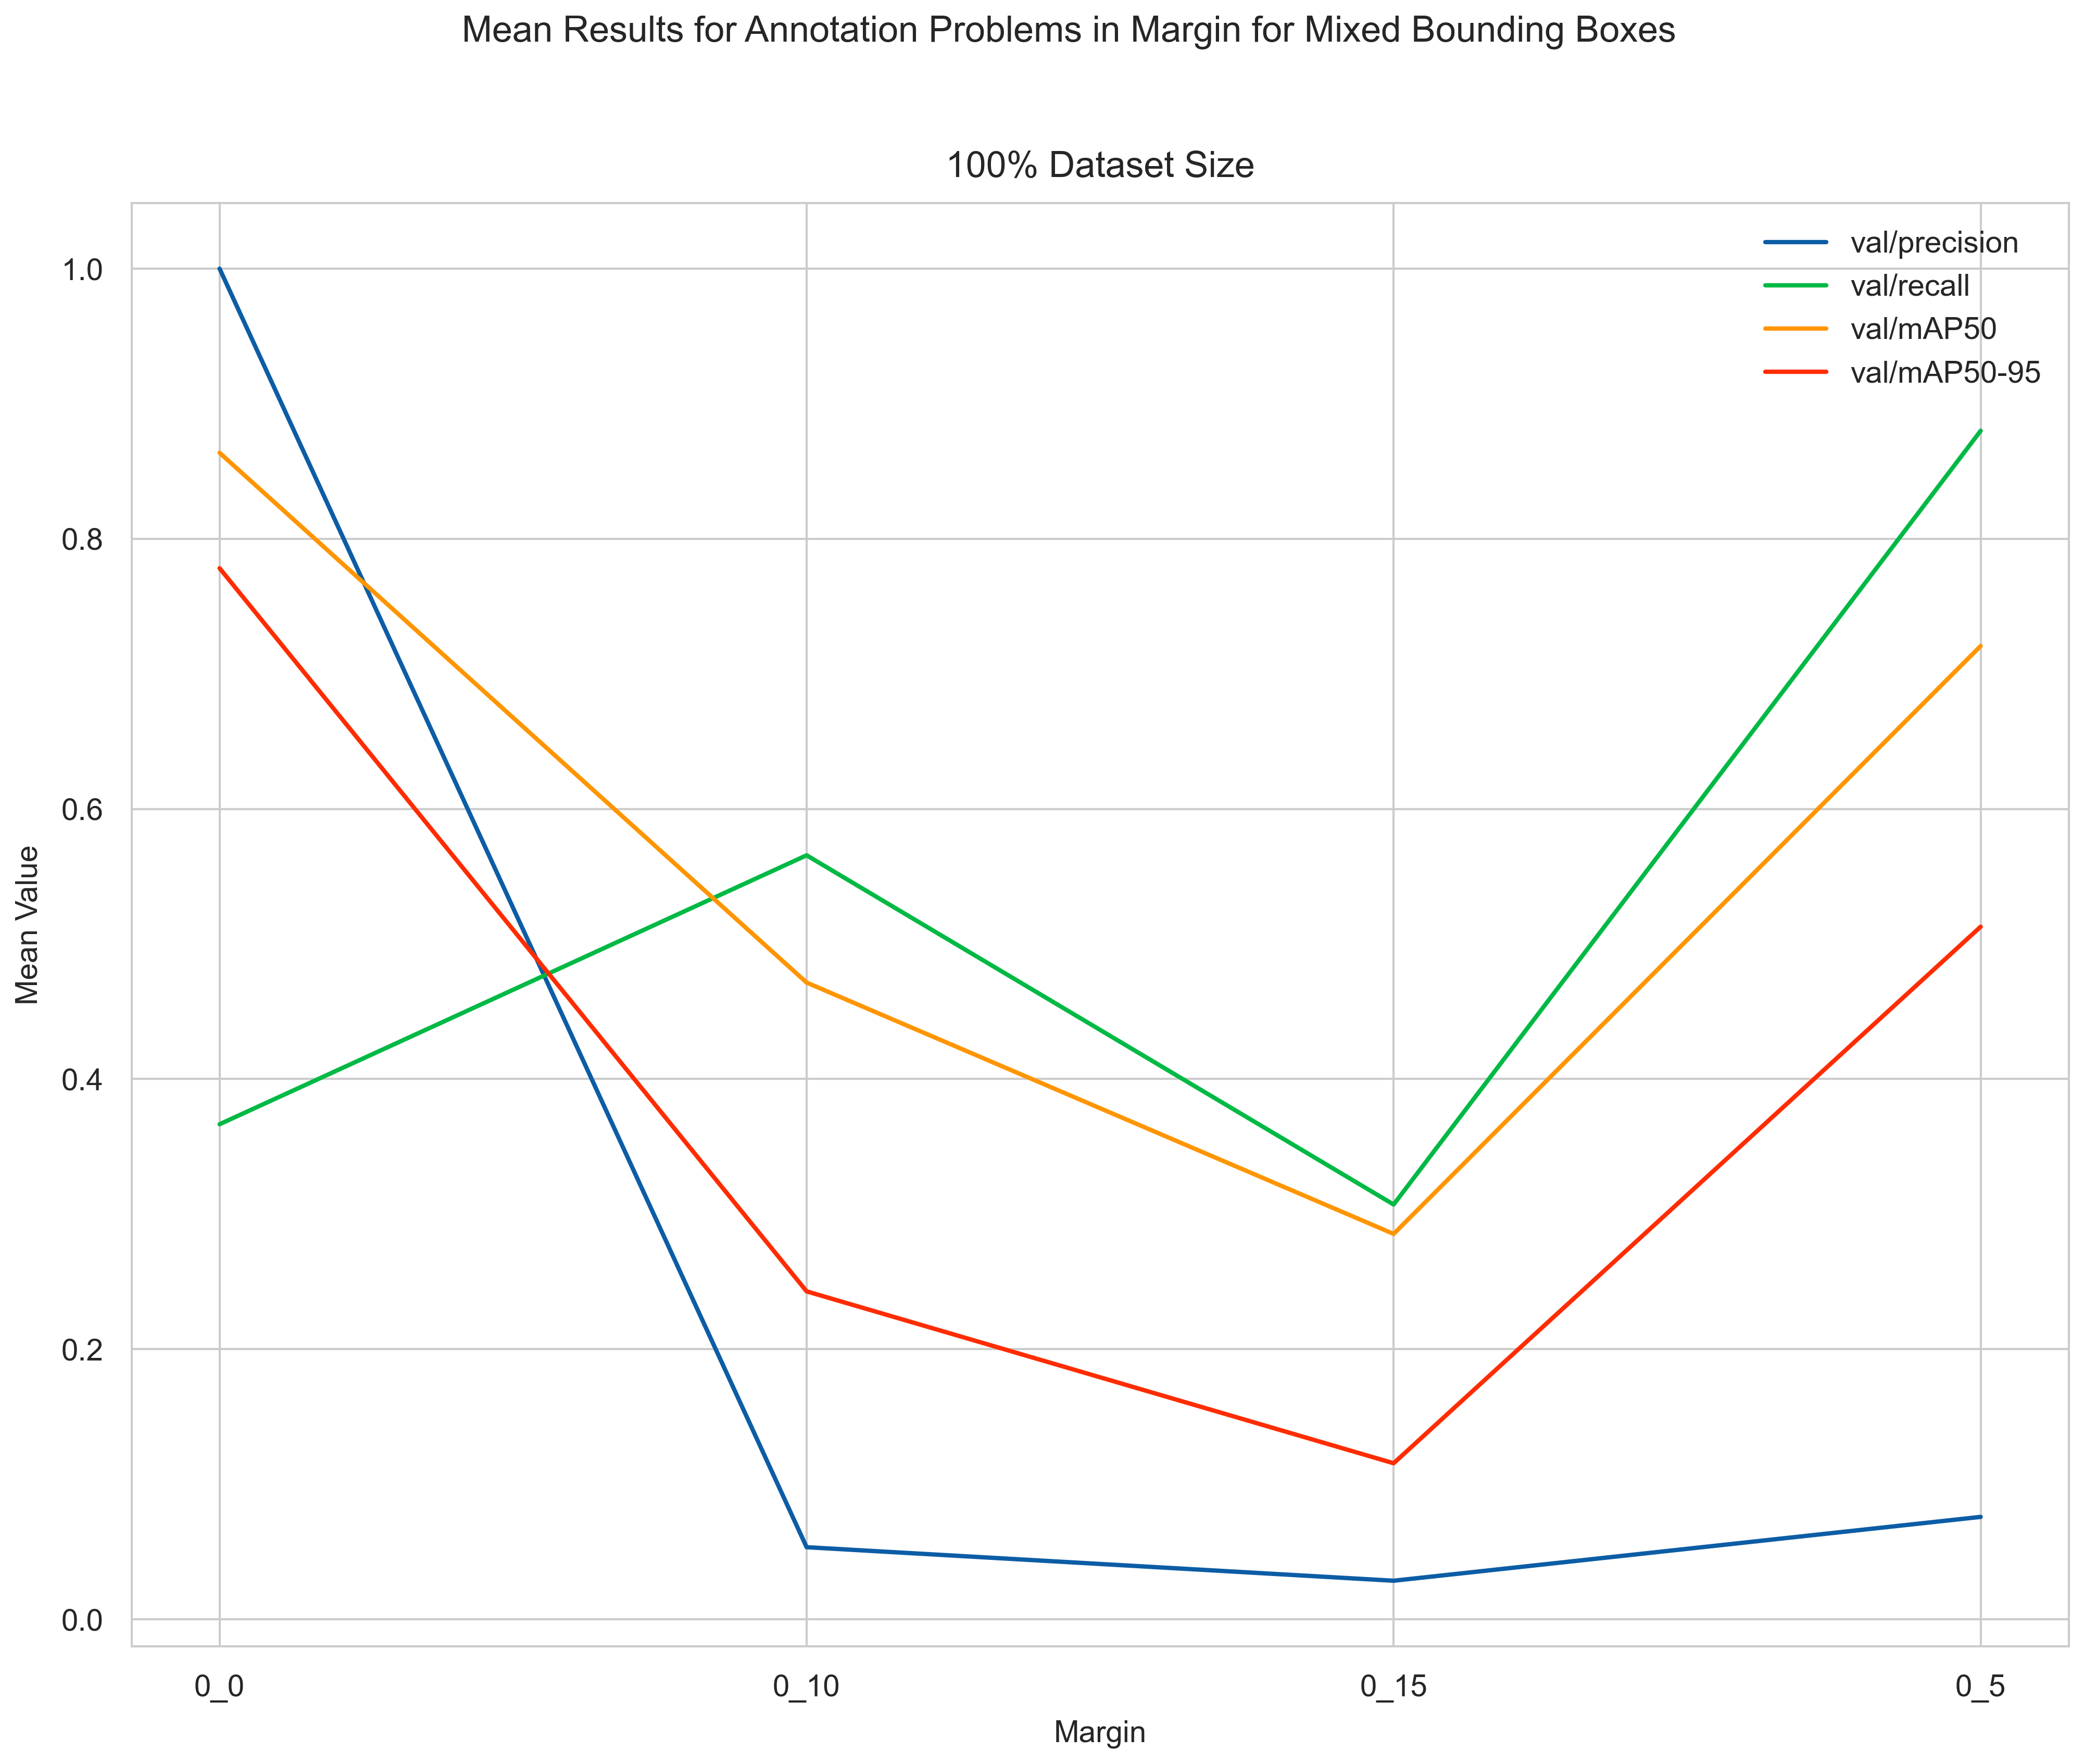

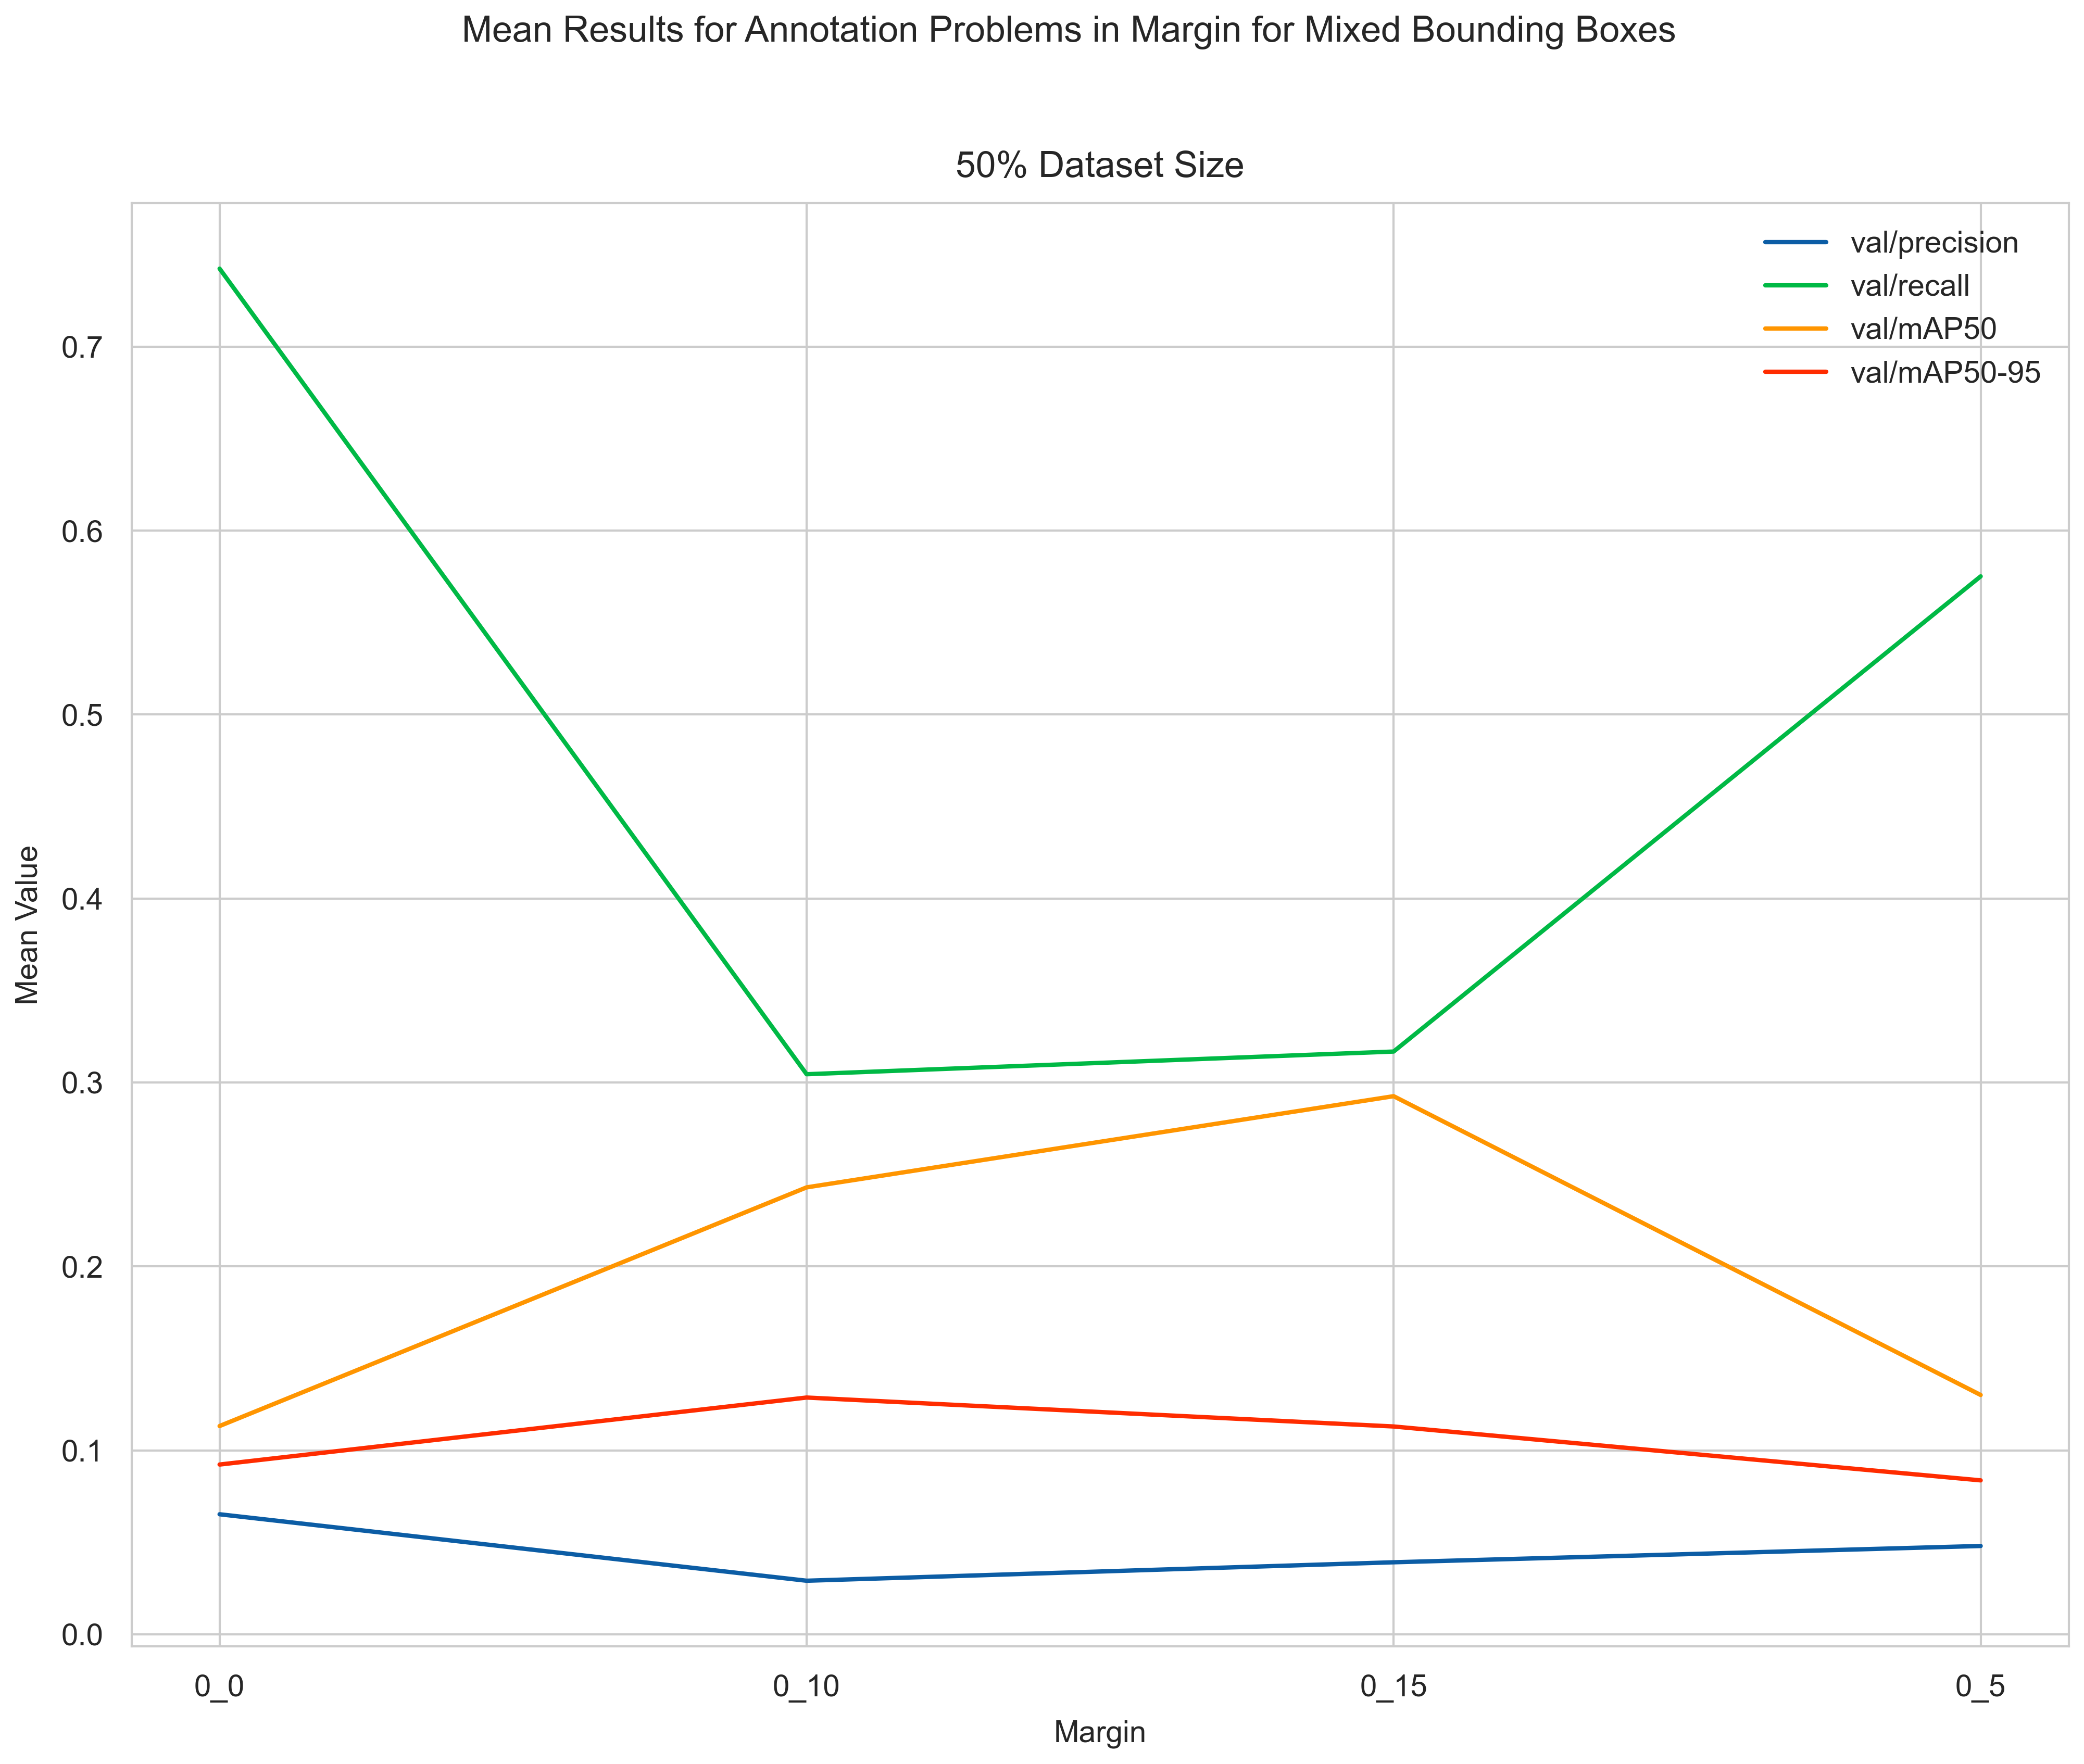

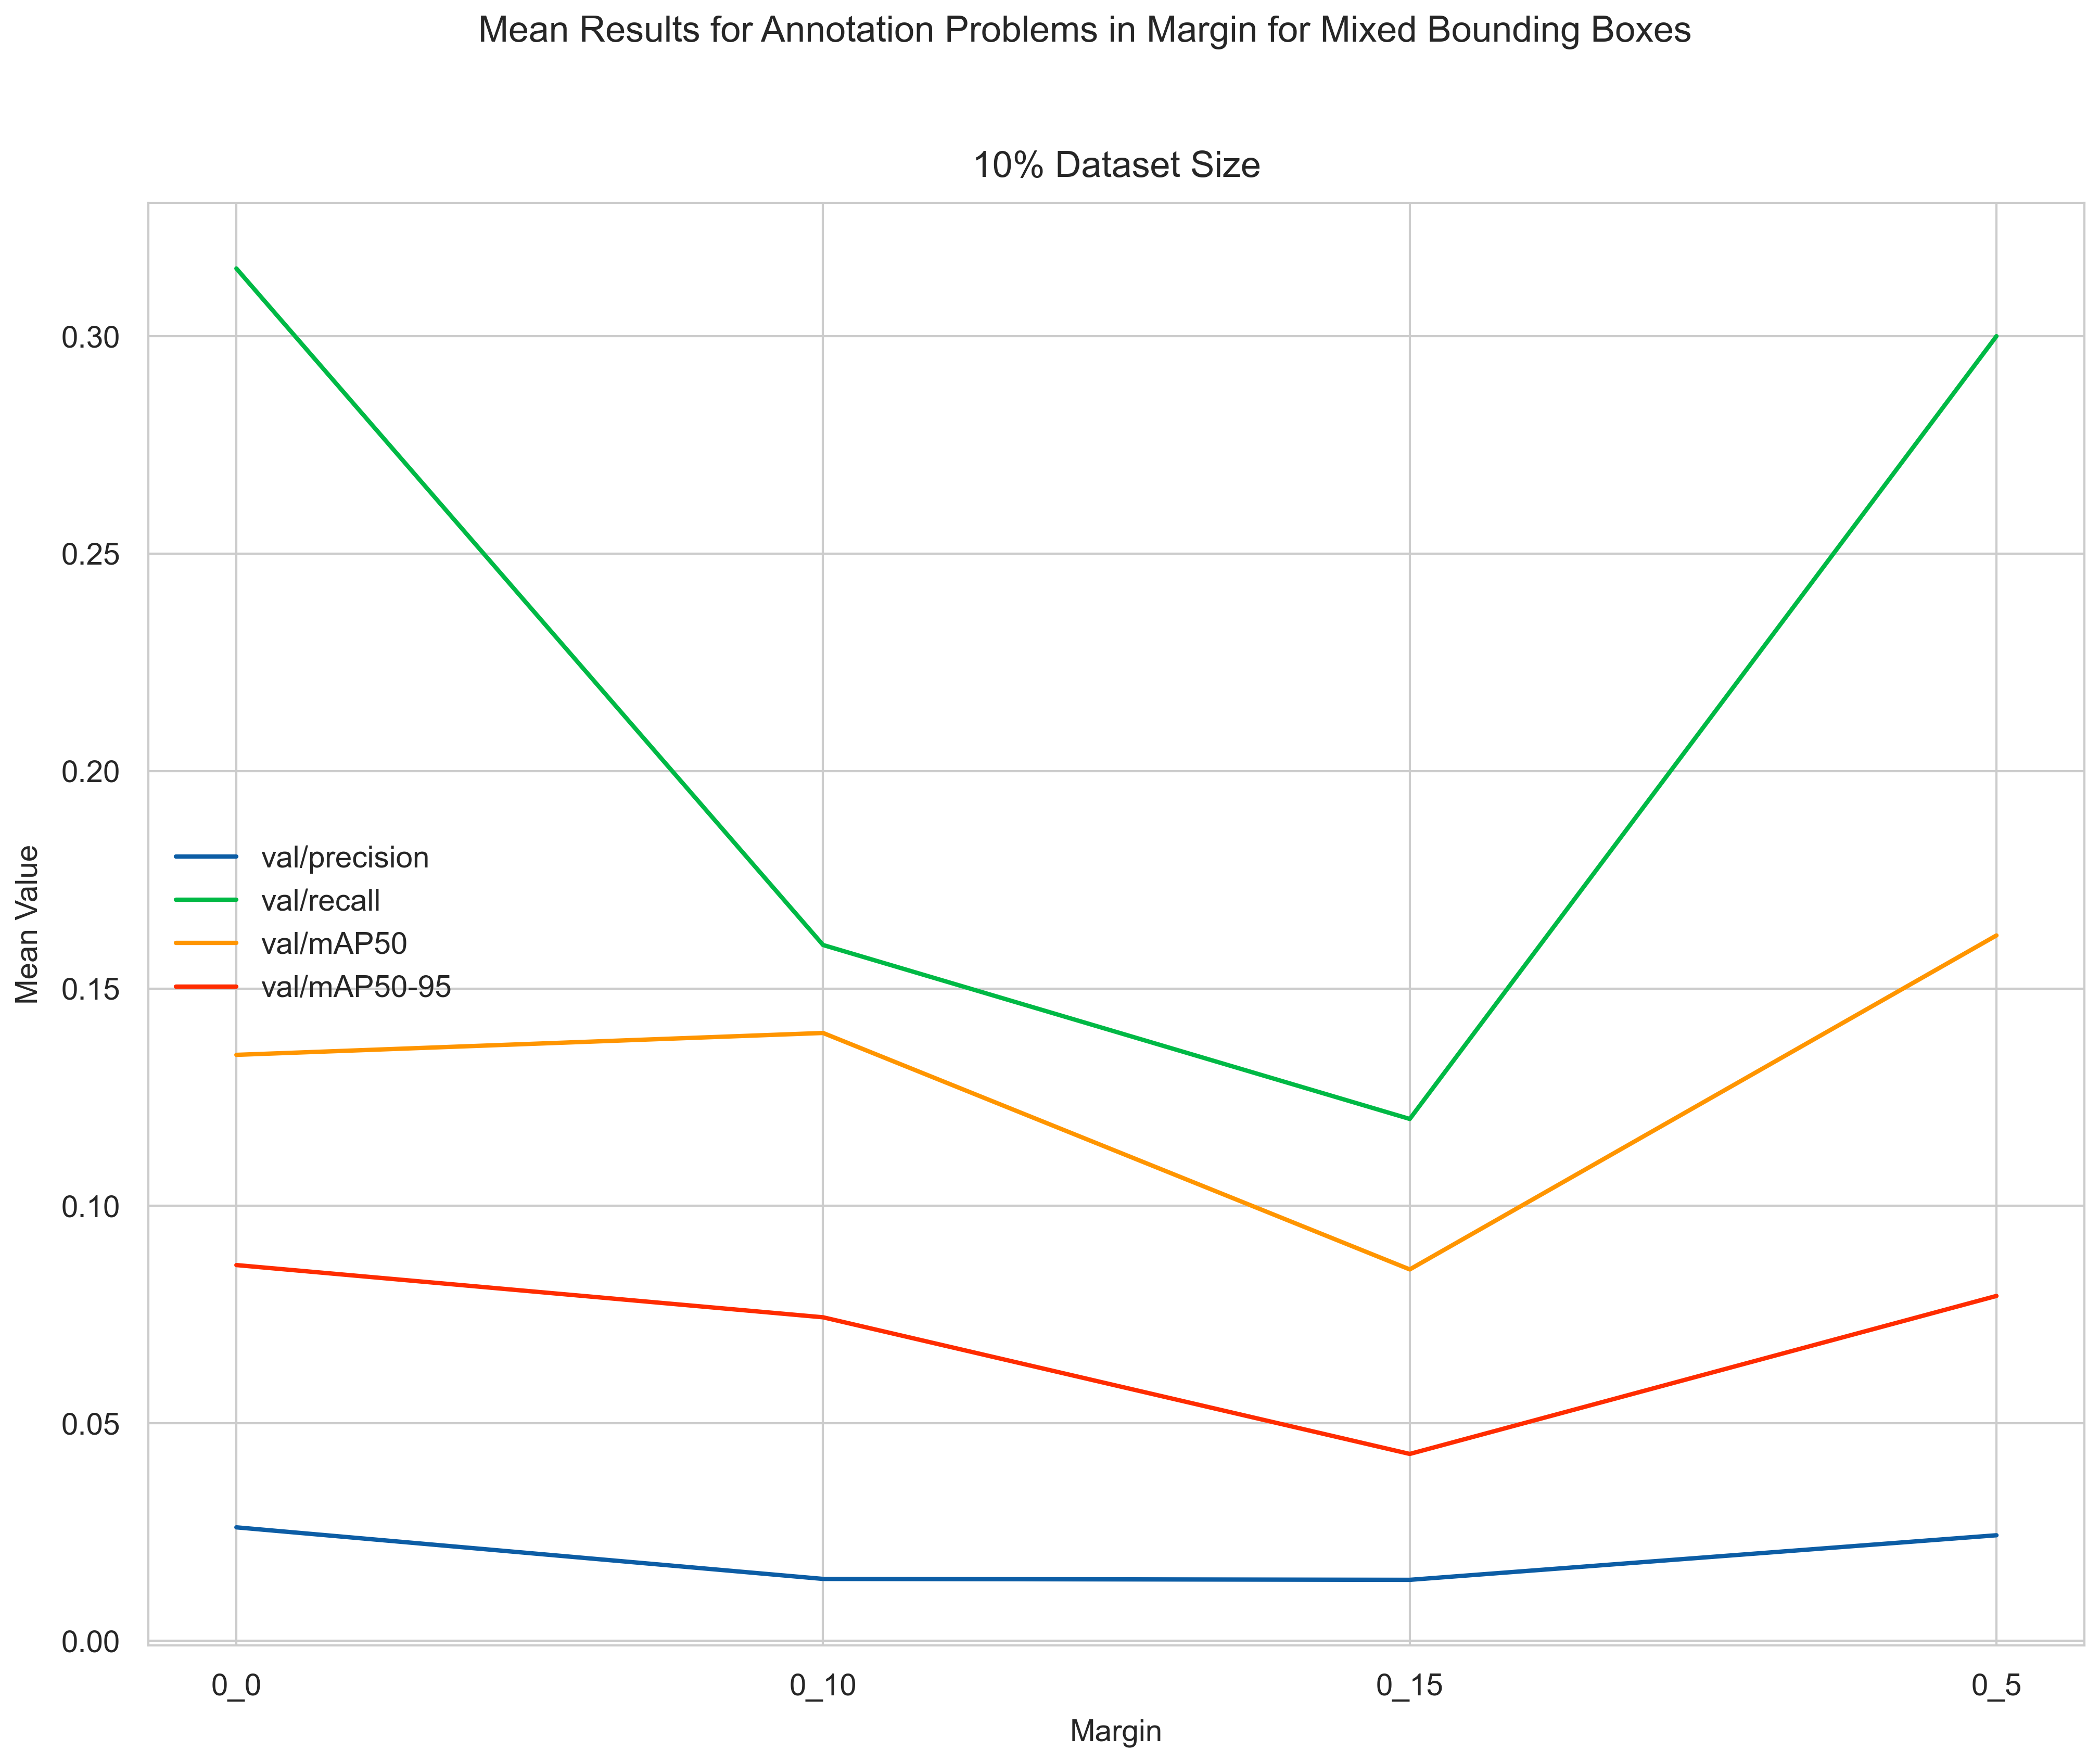

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Defina seus dados e filtros aqui
# Suponha que você já tenha df_filtered e get definidos

sizes = [100, 50, 10]
columns_to_plot = ['val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95']

# Plotar usando Seaborn
sns.set_style("whitegrid")

# Criar um loop sobre os tamanhos
for size in sizes:
    df_filtered = df[((df['type'] == 'bbox_smaller') | (df['type'] == 'bbox_official')) & 
                     (df['right_class'] == 100) & (df['all_class'] == 100) & 
                     (df['size_dataset'] == size)]
    
    mean_values = df_filtered[get].groupby('margin').mean()

    # Criar um subplot para cada tamanho
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Iterar sobre as métricas
    for column in columns_to_plot:
        sns.lineplot(x=mean_values.index, y=mean_values[column], label=column, ax=ax)
    
    ax.set_title(f'{size}% Dataset Size')
    ax.set_xlabel('Margin')
    ax.set_ylabel('Mean Value')
    ax.legend()

    # Adicionar título ao gráfico
    plt.suptitle('Mean Results for Annotation Problems in Margin for Mixed Bounding Boxes')

    # Salvar o gráfico em PNG com 600 DPI
    plt.savefig(f'mean_results_seaborn_{size}.png', dpi=600)

    # Mostrar o gráfico
    plt.show()

In [9]:
# 100% dos dados de treinamento - 6000 imagens
df_filtered = df[((df['type'] == 'bbox_smaller') | (df['type'] == 'bbox_official')) & (df['right_class'] == 100) & (df['all_class'] == 100) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('margin').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
margin,,,,,,,,,,,
0_0,0.999960,1.000000,0.995000,0.994970,0.999816,0.999853,0.999963,0.999908,0.994527,0.976389,0.990647
0_10,0.878490,0.702450,0.784750,0.388450,0.583230,0.814419,0.672621,0.736760,0.237601,0.585407,0.656231
0_15,0.635890,0.410930,0.466510,0.183370,0.385311,0.952877,0.392796,0.556281,0.096435,0.511950,0.603790
0_5,0.984690,0.980920,0.988880,0.724690,0.984888,0.989254,0.995539,0.992386,0.583160,0.776214,0.771173


In [10]:
# 50% dos dados de treinamento - 3000 imagens
df_filtered = df[((df['type'] == 'bbox_smaller') | (df['type'] == 'bbox_official')) & (df['right_class'] == 100) & (df['all_class'] == 100) & (df['size_dataset'] == 50)]
df_filtered[get].groupby('margin').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
margin,,,,,,,,,,,
0_0,0.999840,1.000000,0.995000,0.994900,0.999853,0.999871,0.999982,0.999927,0.994498,0.977077,0.988883
0_10,0.875040,0.704370,0.785090,0.384950,0.527862,0.774575,0.623673,0.690982,0.217387,0.574945,0.656192
0_15,0.700110,0.396490,0.467420,0.183560,0.372965,0.959243,0.378970,0.543299,0.090480,0.520295,0.597612
0_5,0.983690,0.980830,0.989070,0.723250,0.979616,0.983309,0.996181,0.989703,0.580330,0.764490,0.769431


In [11]:
# 10% dos dados de treinamento - 600 imagens
df_filtered = df[((df['type'] == 'bbox_smaller') | (df['type'] == 'bbox_official')) & (df['right_class'] == 100) & (df['all_class'] == 100) & (df['size_dataset'] == 10)]
df_filtered[get].groupby('margin').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
margin,,,,,,,,,,,
0_0,0.999940,0.999790,0.995000,0.993510,0.999670,0.999725,0.999945,0.999835,0.992573,0.981530,0.983552
0_10,0.856310,0.716720,0.771620,0.362300,0.529267,0.724580,0.662560,0.692184,0.211641,0.604268,0.648913
0_15,0.630440,0.402360,0.461330,0.181070,0.324439,0.917620,0.334172,0.489926,0.073008,0.497110,0.592952
0_5,0.983120,0.979440,0.983240,0.680500,0.988839,0.994891,0.993886,0.994388,0.577468,0.771043,0.773386


### Avaliar anotações de classes erradas e em diferentes situações de margem

Aparantemente mesmo com as dificuldades de objetos com anotações com classes erradas, o modelo conseguiu entender as classes corretamente, porém ter um dataset de validação também com as classes erradas fez com que os resultados focem muito mais pessimistas do que realmente seriam em produção, dificultando escolher o melhor modelo durante o treinamento. Segue alguns pensamentos baseados nos resultados:

- Dataset de validação com classes erradas apresentaram resultados completamente distorcidos e pessimistas -> Ironia, mas parece que quanto pior os resultados em validação (com classes erradas) melhor no dataset com classes certas, ou seja, o modelo conseguiu entender as classes corretamente, mesmo que as anotações apontasem para outra direção [talvez ter um dataset de validação com anotações perfeitas já seria suficiente, ou seja, maior dedicação na anotação de validação do que no de treinamento];
- Avaliando os resultados em validação, a porcentagem de acertos ficou muito próximo da porcentagem de anotações com classes erradas -> indicativo que o modelo realmente estava conseguiu classificar as classes verdadeiras, apenas sendo penalizado porque a anotação estava errada. Como estamos utilizando o modelo que apresentou o melhor resultado em validação, acabamos pegando um modelo que teve maior taxa de erros, já que classificamos como melhor modelo aquele que em alguns casos classificou alguns modelos errados, mas que atendeu os critérios das anotações;
- Quanto mais dados com classes erradas, menor a confiança do modelo -> por mais que o modelo tenha conseguido acertar grande parte dos dados, ele teve uma penalidade maior em sua confiança a medida que tinha mais dados com classes erradas;
- Dataset com anotações de bbox menores do que o objeto se mostrou mais estável e com melhores resultados -> os resultados em test ficaram todos praticamente iguais e em relação as anotações maiores e mistas, conseguiu além de ter resultados melhores, também teve uma confiança maior.

**Em resumo:** Mesmo que os dados estejam com até 15% de erros nas anotações de classes o modelo não teve dificuldades para entender cada uma delas, o que pode ter ajudado foi ter o dataset balanceado. Desta forma, se mostra extremamente importante ter as anotações de classes corretas pelo menos no dataset de validação, pois como o modelo consegue entender as classes mesmo tendo algumas erradas no treinamento, isso irá causar falsos resultados pessimistas no dataset de validação, já que o modelo irá informar a classe verdadeira. Inclusive os resultados se aproximaram muito do treinamento realizado com apenas dados perfeitamente anotados, mostrando que não é de extrema rigorosidade a necessidade de ter as classes 100% corretas. OBS: Lembrando que a complexidade deste dataset não é muito alta, tendo apenas as classes retângulo e circulo que possuem formatos bem definidos.

In [12]:
get = ['right_class', 'val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95',
       'test/accuracy', 'test/precision', 'test/recall', 'test/fscore',
       'test/mAP50-95', 'test/mean_confidence', 'test/mean_IoU']

In [13]:
# Resultados dados perfeitamente anotados para fins de comparação
df_filtered = df[((df['type'] == 'bbox_official')) & (df['margin'] == '0_0') & (df['right_class'] == 100) & (df['all_class'] == 100)]
df_filtered[get].groupby('right_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
right_class,,,,,,,,,,,
100,0.999913,0.999930,0.995000,0.994460,0.999780,0.999816,0.999963,0.999890,0.993866,0.978332,0.987694


In [14]:
# Média dos resultados de margem de 0_5 mistas e com erros de classificação
df_filtered = df[((df['type'] == 'bbox_larger_smaller')) & (df['margin'] == '0_5') & (df['all_class'] == 100)]
df_filtered[get].groupby('right_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
right_class,,,,,,,,,,,
85,0.826097,0.822923,0.800540,0.488380,0.980152,0.989109,0.990808,0.989941,0.948420,0.575050,0.960299
90,0.871050,0.868530,0.853127,0.522033,0.974386,0.991277,0.982986,0.986950,0.942195,0.603326,0.960714
95,0.920737,0.920020,0.916713,0.566683,0.963271,0.964178,0.999033,0.981251,0.960552,0.635111,0.962580
100,0.970160,0.968567,0.983503,0.618350,0.973142,0.973530,0.999590,0.986375,0.964537,0.679476,0.964487


In [15]:
# Média dos resultados de margem de 0_5 maiores e com erros de classificação
df_filtered = df[((df['type'] == 'bbox_larger')) & (df['margin'] == '0_5') & (df['all_class'] == 100)]
df_filtered[get].groupby('right_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
right_class,,,,,,,,,,,
85,0.846363,0.848970,0.821737,0.637253,0.908624,0.999502,0.909118,0.947170,0.569062,0.628181,0.796928
90,0.896940,0.897037,0.874470,0.680870,0.997936,0.998837,0.999094,0.998966,0.604612,0.743972,0.786394
95,0.951877,0.951993,0.938553,0.733607,0.999168,0.999425,0.999743,0.999584,0.614005,0.804461,0.789693
100,0.999640,0.999693,0.994973,0.783573,0.920118,0.999573,0.920525,0.954695,0.580369,0.711410,0.798105


In [16]:
# Média dos resultados de margem de 0_5 menores e com erros de classificação
df_filtered = df[((df['type'] == 'bbox_smaller')) & (df['margin'] == '0_5') & (df['all_class'] == 100)]
df_filtered[get].groupby('right_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
right_class,,,,,,,,,,,
85,0.839997,0.834923,0.812067,0.566860,0.979695,0.990448,0.989033,0.989735,0.559074,0.647087,0.764240
90,0.882530,0.880300,0.862437,0.604597,0.987807,0.991833,0.995906,0.993865,0.573174,0.712728,0.770904
95,0.936490,0.933687,0.927490,0.650710,0.984477,0.987647,0.996750,0.992176,0.582309,0.753898,0.772922
100,0.983833,0.980397,0.987063,0.709480,0.984448,0.989151,0.995202,0.992159,0.580320,0.770583,0.771330


#### Quantidade de dados diferente
Está é uma métrica que não se mostrou muito representativo com mundo real, já que a complexidade do ambiente é extremamente simples, pois os fundo nunca muda e os objetos são sempre praticamente iguais, mudando apenas suas localizações. Então foi utilizado o pensamento de ter treinado por mais épocas e não necessáriamente adicionar mais dados. Segue alguns pensamentos baseados nos resultados:

- Não foi constatados mudanças significativas por ter mais dados ou tempo de treinamento -> com apenas 10% dos dados já foi suficiente para o modelo entender que as classes estavam erradas e atingir o seu melhor resultado.

**Em resumo:** Sem mudanças significativas.

In [17]:
# 100% dos dados de treinamento - 6000 imagens
df_filtered = df[((df['type'] == 'bbox_smaller')) & (df['margin'] == '0_5') & (df['all_class'] == 100) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('right_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
right_class,,,,,,,,,,,
85,0.837780,0.836330,0.809900,0.577810,0.987918,0.994014,0.993831,0.993922,0.573426,0.652897,0.767450
90,0.885580,0.884260,0.865430,0.616090,0.990242,0.993359,0.996842,0.995097,0.581362,0.709440,0.771471
95,0.935270,0.932810,0.926300,0.659250,0.983936,0.988584,0.995245,0.991903,0.580008,0.737529,0.769949
100,0.984690,0.980920,0.988880,0.724690,0.984888,0.989254,0.995539,0.992386,0.583160,0.776214,0.771173


In [18]:
# 50% dos dados de treinamento - 3000 imagens
df_filtered = df[((df['type'] == 'bbox_smaller')) & (df['margin'] == '0_5') & (df['all_class'] == 100) & (df['size_dataset'] == 50)]
df_filtered[get].groupby('right_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
right_class,,,,,,,,,,,
85,0.836190,0.834670,0.809710,0.571080,0.975310,0.985748,0.989259,0.987501,0.557274,0.655344,0.763024
90,0.883650,0.882810,0.865080,0.614910,0.988262,0.991130,0.997081,0.994097,0.584757,0.704488,0.773545
95,0.935250,0.934050,0.927770,0.657800,0.981707,0.984483,0.997136,0.990769,0.578061,0.752028,0.769364
100,0.983690,0.980830,0.989070,0.723250,0.979616,0.983309,0.996181,0.989703,0.580330,0.764490,0.769431


In [19]:
# 10% dos dados de treinamento - 600 imagens
df_filtered = df[((df['type'] == 'bbox_smaller')) & (df['margin'] == '0_5') & (df['all_class'] == 100) & (df['size_dataset'] == 10)]
df_filtered[get].groupby('right_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
right_class,,,,,,,,,,,
85,0.846020,0.833770,0.816590,0.551690,0.975856,0.991582,0.984008,0.987781,0.546522,0.633020,0.762246
90,0.878360,0.873830,0.856800,0.582790,0.984915,0.991010,0.993794,0.992400,0.553403,0.724257,0.767697
95,0.938950,0.934200,0.928400,0.635080,0.987787,0.989874,0.997870,0.993856,0.588857,0.772136,0.779453
100,0.983120,0.979440,0.983240,0.680500,0.988839,0.994891,0.993886,0.994388,0.577468,0.771043,0.773386


### Avaliar anotações de objetos faltando e em diferentes situações de margem
Tenho que admitir que tive um bug cerebral bem forte ao tentar analisar estes dados, algumas explicações estavam mais escondidas do que o esperado, até suspeitei de erros nos dados, mas não encontrei nenhuma divergência e depois de uma boa analisada foi psosível chegar nas conclusões. Para chegar as conclusões, foi separado os dados contendo 100% dos dados e outra com 10% dos dados. Segue alguns pensamentos baseados nos resultados:

- Não anotar objetos causau uma queda significante na confiança do modelo -> analisando os casos com 100% dos dados podemos ver nitidamente a queda de confiança dos modelos conforme a quantidade de objetos faltando serem anotados no dataset;
-Mesmo com grandes quantidade de objetos faltando anotações o modelo conseguiu aprender as classes corretas e como localizá-los -> os resultados em validação sofreram uma penalidade semelhante a quantidade de erros de anotação, já nos testes que estavam com anotação corretas ficaram próximos do valor máximo, mostrando que não anotar alguns objetos não prejudicaram significativamente o aprendizado do modelo, porém levou a um resultado pesimista nas validações  [talvez ter um dataset de validação com anotações perfeitas já seria suficiente, ou seja, maior dedicação na anotação de validação do que no de treinamento];
- Resultados do IoU não tiveram mudanças significativas -> ter muitos ou nenhum objeto faltando não afetou a precisão dos bounding boxes;
- Ao utilizar um dataset menor com erros de anotação fez com que o modelo ficasse com confianças ainda mais baixas e com resultados imprevisíveis -> olhando principalmente para o bbox_larger com 15% de erros de anotação a média da confiança ficou em 0.46 o que fica muito próximo do threshold mínimo de confiança usado nos testes que é de 0.25, resultando em um recall muito mais baixo em teste do que em validação que foi utilizado uma confiança mínima de 0.001. Ao mesmo tempo se mostrou com um certo teor de sorte, já que com 10% e 5% de erros a confinaça ficaram relativamente altos, mas com 0% de erros a confiança ficou bem baixa, mostrando o grau de aleatoridade ao treinar com poucos dados/épocas até mesmo dataset sem erros de anotação.

**Em resumo:** Talvez por não estarmos lidando com um cenário muito complexo o fato de termos representações suficientes dos objetos é suficiente para suprir erros de objetos não anotados, porém isso não é suficiente para suprir um modelo com alta confiança, ou seja, quanto mais objetos estão faltando anotação, pior será a confianças das detecções do modelo.

In [20]:
get = ['all_class', 'val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95',
       'test/accuracy', 'test/precision', 'test/recall', 'test/fscore',
       'test/mAP50-95', 'test/mean_confidence', 'test/mean_IoU']

In [21]:
df_filtered = df[((df['type'] == 'bbox_official')) & (df['margin'] == '0_0') & (df['right_class'] == 100)]
df_filtered[get].groupby('all_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
all_class,,,,,,,,,,,
100,0.999913,0.999930,0.995000,0.994460,0.999780,0.999816,0.999963,0.999890,0.993866,0.978332,0.987694


In [22]:
# bbox_larger_smaller - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[((df['type'] == 'bbox_larger_smaller')) & (df['margin'] == '0_5') & (df['right_class'] == 100) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('all_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
all_class,,,,,,,,,,,
85,0.824870,0.968450,0.839430,0.532430,0.989822,0.993410,0.996365,0.994885,0.980030,0.588492,0.974755
90,0.874600,0.969960,0.887430,0.561090,0.982872,0.984063,0.998770,0.991362,0.979246,0.620270,0.973229
95,0.921750,0.968370,0.935540,0.594250,0.980604,0.981790,0.998770,0.990207,0.976096,0.637547,0.971332
100,0.971430,0.968930,0.983390,0.625630,0.981680,0.982070,0.999596,0.990756,0.980560,0.679293,0.973877


In [23]:
# bbox_larger - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[((df['type'] == 'bbox_larger')) & (df['margin'] == '0_5') & (df['right_class'] == 100) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('all_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
all_class,,,,,,,,,,,
85,0.849340,0.999980,0.849390,0.681510,0.999339,0.999468,0.999871,0.999670,0.615410,0.712684,0.789096
90,0.899590,1.000000,0.897120,0.721080,0.999523,0.999633,0.999890,0.999761,0.619499,0.761338,0.791287
95,0.949250,0.999980,0.946370,0.763880,0.999523,0.999615,0.999908,0.999761,0.622227,0.801775,0.790366
100,0.999870,1.000000,0.994950,0.802250,0.999376,0.999523,0.999853,0.999688,0.632392,0.850430,0.795129


In [24]:
# bbox_smaller - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[((df['type'] == 'bbox_smaller')) & (df['margin'] == '0_5') & (df['right_class'] == 100) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('all_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
all_class,,,,,,,,,,,
85,0.835840,0.980240,0.843440,0.616620,0.984599,0.992668,0.991811,0.992240,0.569319,0.652659,0.767420
90,0.884920,0.979770,0.890550,0.650020,0.981963,0.988240,0.993574,0.990900,0.567679,0.700827,0.765965
95,0.933410,0.979260,0.939400,0.689390,0.984490,0.990306,0.994070,0.992184,0.575976,0.730748,0.768963
100,0.984690,0.980920,0.988880,0.724690,0.984888,0.989254,0.995539,0.992386,0.583160,0.776214,0.771173


#### Quantidade de dados diferente

In [25]:
# bbox_larger_smaller - 10% dos dados de treinamento (600 imagens)
df_filtered = df[((df['type'] == 'bbox_larger_smaller')) & (df['margin'] == '0_5') & (df['right_class'] == 100) & (df['size_dataset'] == 10)]
df_filtered[get].groupby('all_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
all_class,,,,,,,,,,,
85,0.824710,0.966200,0.850790,0.520560,0.980603,0.983658,0.996842,0.990206,0.927309,0.587538,0.944814
90,0.864270,0.963640,0.887350,0.540590,0.980649,0.985842,0.994657,0.990230,0.933909,0.599382,0.949323
95,0.905130,0.961150,0.934040,0.574200,0.957005,0.986860,0.969357,0.978030,0.877578,0.518959,0.935364
100,0.967610,0.968070,0.982870,0.603980,0.973712,0.974025,0.999670,0.986681,0.942574,0.692578,0.950520


In [26]:
# bbox_larger - 10% dos dados de treinamento (600 imagens)
df_filtered = df[((df['type'] == 'bbox_larger')) & (df['margin'] == '0_5') & (df['right_class'] == 100) & (df['size_dataset'] == 10)]
df_filtered[get].groupby('all_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
all_class,,,,,,,,,,,
85,0.855040,0.995300,0.861160,0.651060,0.407979,1.000000,0.407979,0.579525,0.307698,0.458270,0.859091
90,0.901820,0.999390,0.900480,0.676630,0.990233,0.996209,0.993978,0.995092,0.549897,0.579625,0.766802
95,0.950640,0.999980,0.949880,0.730900,0.999339,0.999504,0.999835,0.999670,0.602662,0.804814,0.789124
100,0.999210,0.999080,0.994990,0.748480,0.761878,0.999855,0.761962,0.864847,0.487897,0.442680,0.809486


In [27]:
# bbox_smaller - 10% dos dados de treinamento (600 imagens)
df_filtered = df[((df['type'] == 'bbox_smaller')) & (df['margin'] == '0_5') & (df['right_class'] == 100) & (df['size_dataset'] == 10)]
df_filtered[get].groupby('all_class').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
all_class,,,,,,,,,,,
85,0.845570,0.940060,0.848260,0.575630,0.292494,1.000000,0.292494,0.452605,0.227779,0.371224,0.872932
90,0.894840,0.934660,0.888650,0.605290,0.379888,1.000000,0.379888,0.550607,0.282669,0.412721,0.856430
95,0.931510,0.975680,0.934590,0.647580,0.995014,0.998326,0.996677,0.997501,0.591927,0.771682,0.779021
100,0.983120,0.979440,0.983240,0.680500,0.988839,0.994891,0.993886,0.994388,0.577468,0.771043,0.773386


## Diferentes cenários de erros de anotação
Vamos ser sincero, não é tão simples assim termos um dataset 100% certo, seja na precisão dos bounding boxes, quanto nas classes e todos objetos anotados. Não só por falta de atenção nas anotações, mas pelo cansaço de ficar horas anotando consecutivamente ou até mesmo problemas complexos de identificar. Então vamos realizar algumas comparações entre diferentes taxas de erros nos datasets e ver o quanto isso pode prejudicar. Segue alguns pensamentos baseados nos resultados:

- Algo nítico e que já foi identificado em diversos cenários anteriores, quanto maior o erro de anotação, menor a confiança do modelo -> conforme vamos tendo mais erros de qualquer tipo, a confiança do modelo diminui;
- O IoU do modelo só é impatacada com a imprecisão dos bounding boxes e não com os outros erros -> Mesmo aumentando os outros tipos de erros o IoU apresentou quase o mesmo valor para cada uma das categorias de precisão dos bounding boxes
- Com uma grande quantidade de dados representando muito bem todos os objetos e cenários o resultado em geral não parece ser impatado significativamente -> por mais que seja dificil identificar a qualidade do modelo analisando a validação que possuem problemas de anotação, os modelos em geral conseguiram contornar os problemas de anotação e entender corretamente os objetos e suas classes, a ponto que em todas as taxas de erros o precision e recall ficaram próximos dos valores máximos. Lembrando que este é um problema simples e com baixa complexidade, tendo exemplos suficientemente grande de cada objetos e em cada cenário possível.
- No momento que tiver uma quantidade de dados significativas suficiente, não adianta adicionar mais dados, pois os resultados irão continuar iguais, incluindo a confiança -> comparando o dataset com 100% (6 mil em treinamento) e 50% (3 mil em treinamento) dos dados, os resultados não tiveram mudanças significativas, mostrando que nem sempre adinta adicionar mais dados se as anotações são questionáveis.
- Possivelmente é mais importante ter dados extremamente bem anotados do que quantidade (qualidade é melhor que quantidade) -> analisando o bbox_official com as 3 quantidades de dados podemos ver que os resultados foram praticamente iguais, ou seja, neste cenário vale mais a pena anotar com muita atenção 600 dados de treinamento do que 6 mil mal anotados, resultando nos mesmo valores das métricas, mas com menos tempo de treinamento. Lembrando que neste cenário 600 imagens já foram suficientes para representar todos os cenários possíveis (fundo branco);
- Anotações no dataset de validação com problema geram métricas completamente incompatíveis com a realidade -> podemos ver que todos os modelos consegueriam aprender a classificar e localizar os objetos, mas isso não se mostrou uma realidade na validação, porque o modelo estava informando as repostas corretas, mas como a validação estava com anotações erradas, fez com que o modelo fosse penalizando. Isso também pode ter levado a escolher o melhor modelo que não era realmente o melhor, apenas o que se adaptou melhor aos dados com problemas de anotação.


**Em resumo:** É mais interessante priorizar uma anotação de alta qualidade do que grande quantidade de dados. Possivelmente é melhor realizar a anotação das imagens e depois fazer a revisão de todas elas, do que anotar o dobro de imagens (lembrando que revisão é muito mais rápida de fazer em relação a anotação). Inclusive dados de validação com baixa qualidade irão resultado em métricas questionáveis, não representam a realidade, podendo fazer com que discartemos modelos sendo que eles estão bons.

In [28]:
get = ['type', 'val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95',
       'test/accuracy', 'test/precision', 'test/recall', 'test/fscore',
       'test/mAP50-95', 'test/mean_confidence', 'test/mean_IoU']

In [29]:
# 100% correto - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[((df['margin'] == '0_0') | (df['margin'] == '0_5')) & (df['right_class'] == 100) & (df['all_class'] == 100) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.999870,1.000000,0.994950,0.802250,0.999376,0.999523,0.999853,0.999688,0.632392,0.850430,0.795129
bbox_larger_smaller,0.971430,0.968930,0.983390,0.625630,0.981680,0.982070,0.999596,0.990756,0.980560,0.679293,0.973877
bbox_official,0.999960,1.000000,0.995000,0.994970,0.999816,0.999853,0.999963,0.999908,0.994527,0.976389,0.990647
bbox_smaller,0.984690,0.980920,0.988880,0.724690,0.984888,0.989254,0.995539,0.992386,0.583160,0.776214,0.771173


In [30]:
# 95% correto - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 95) & (df['all_class'] == 95) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.902880,0.948970,0.888720,0.703360,0.999028,0.999358,0.999670,0.999514,0.610151,0.755242,0.785119
bbox_larger_smaller,0.878610,0.920030,0.868670,0.540980,0.983875,0.985694,0.998127,0.991872,0.977508,0.615313,0.972558
bbox_smaller,0.888450,0.930670,0.879920,0.627200,0.989895,0.993465,0.996383,0.994922,0.582943,0.701571,0.772139


In [31]:
# 90% correto - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 90) & (df['all_class'] == 90) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.811520,0.901410,0.790680,0.625350,0.999560,0.999633,0.999927,0.999780,0.619240,0.693905,0.790747
bbox_larger_smaller,0.788740,0.872710,0.768190,0.477740,0.986204,0.989947,0.996181,0.993054,0.975788,0.565172,0.972461
bbox_smaller,0.799700,0.885020,0.781650,0.555210,0.985921,0.993275,0.992546,0.992910,0.587580,0.641618,0.775877


In [32]:
# 85% correto - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 85) & (df['all_class'] == 85) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.721940,0.850770,0.695830,0.549630,0.999560,0.999615,0.999945,0.999780,0.620231,0.616224,0.790612
bbox_larger_smaller,0.700280,0.823850,0.677120,0.418400,0.970855,0.999603,0.971230,0.985212,0.951651,0.492815,0.970397
bbox_smaller,0.711130,0.834650,0.687700,0.488660,0.991007,0.997585,0.993390,0.995483,0.586916,0.573431,0.775259


In [33]:
# 85% correto e margem de 0_15 - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[(df['margin'] == '0_15') & (df['right_class'] == 85) & (df['all_class'] == 85) & (df['size_dataset'] == 100)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.702470,0.822530,0.675990,0.341080,0.291839,0.453331,0.450318,0.451819,0.115466,0.489043,0.610734
bbox_larger_smaller,0.489820,0.334280,0.320700,0.114820,0.188760,1.000000,0.188760,0.317575,0.169549,0.344114,0.937074
bbox_smaller,0.532010,0.340370,0.307310,0.117710,0.258209,0.990099,0.258877,0.410439,0.063780,0.441764,0.602667


In [34]:
# 100% correto - 50% dos dados de treinamento (3000 imagens)
df_filtered = df[((df['margin'] == '0_0') | (df['margin'] == '0_5')) & (df['right_class'] == 100) & (df['all_class'] == 100) & (df['size_dataset'] == 50)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.999840,1.000000,0.994980,0.799990,0.999101,0.999339,0.999761,0.999550,0.620817,0.841121,0.789699
bbox_larger_smaller,0.971440,0.968700,0.984250,0.625440,0.964034,0.964495,0.999504,0.981688,0.970477,0.666557,0.969064
bbox_official,0.999840,1.000000,0.995000,0.994900,0.999853,0.999871,0.999982,0.999927,0.994498,0.977077,0.988883
bbox_smaller,0.983690,0.980830,0.989070,0.723250,0.979616,0.983309,0.996181,0.989703,0.580330,0.764490,0.769431


In [35]:
# 95% correto - 50% dos dados de treinamento (3000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 95) & (df['all_class'] == 95) & (df['size_dataset'] == 50)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.901840,0.950810,0.889750,0.701910,0.998514,0.999082,0.999431,0.999257,0.614266,0.758184,0.788593
bbox_larger_smaller,0.876790,0.919900,0.870040,0.537970,0.978944,0.980161,0.998733,0.989360,0.967671,0.621927,0.964971
bbox_smaller,0.886830,0.931900,0.879570,0.625920,0.986710,0.990167,0.996475,0.993311,0.576414,0.694286,0.768975


In [36]:
# 90% correto - 50% dos dados de treinamento (3000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 90) & (df['all_class'] == 90) & (df['size_dataset'] == 50)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.811750,0.902590,0.791700,0.620230,0.999358,0.999504,0.999853,0.999679,0.600770,0.702258,0.786373
bbox_larger_smaller,0.788790,0.873830,0.773590,0.476030,0.991989,0.996125,0.995832,0.995979,0.976039,0.572969,0.972323
bbox_smaller,0.799230,0.885480,0.781610,0.551140,0.986633,0.994533,0.992013,0.993272,0.568622,0.638513,0.769734


In [37]:
# 85% correto - 50% dos dados de treinamento (3000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 85) & (df['all_class'] == 85) & (df['size_dataset'] == 50)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.720310,0.849870,0.695020,0.533420,0.997947,0.998587,0.999357,0.998972,0.564962,0.621292,0.769527
bbox_larger_smaller,0.698530,0.823330,0.676910,0.414840,0.983808,0.998734,0.985037,0.991838,0.965014,0.499534,0.971743
bbox_smaller,0.708740,0.833570,0.687490,0.482960,0.982954,0.992910,0.989902,0.991404,0.560676,0.565360,0.766354


In [38]:
# 100% correto - 10% dos dados de treinamento (600 imagens)
df_filtered = df[((df['margin'] == '0_0') | (df['margin'] == '0_5')) & (df['right_class'] == 100) & (df['all_class'] == 100) & (df['size_dataset'] == 10)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.999210,0.999080,0.994990,0.748480,0.761878,0.999855,0.761962,0.864847,0.487897,0.442680,0.809486
bbox_larger_smaller,0.967610,0.968070,0.982870,0.603980,0.973712,0.974025,0.999670,0.986681,0.942574,0.692578,0.950520
bbox_official,0.999940,0.999790,0.995000,0.993510,0.999670,0.999725,0.999945,0.999835,0.992573,0.981530,0.983552
bbox_smaller,0.983120,0.979440,0.983240,0.680500,0.988839,0.994891,0.993886,0.994388,0.577468,0.771043,0.773386


In [39]:
# 95% correto - 10% dos dados de treinamento (600 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 95) & (df['all_class'] == 95) & (df['size_dataset'] == 10)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.900610,0.930600,0.889040,0.671220,0.845854,0.999957,0.845886,0.916491,0.550244,0.444750,0.814974
bbox_larger_smaller,0.864450,0.910890,0.865640,0.526280,0.970071,0.971996,0.997962,0.984808,0.928115,0.597965,0.945110
bbox_smaller,0.881270,0.924790,0.873820,0.595330,0.976757,0.990447,0.986046,0.988242,0.570352,0.647531,0.773888


In [40]:
# 90% correto - 10% dos dados de treinamento (600 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 90) & (df['all_class'] == 90) & (df['size_dataset'] == 10)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.804630,0.893900,0.792960,0.598670,0.969023,0.999508,0.969486,0.984268,0.586891,0.507927,0.793786
bbox_larger_smaller,0.783250,0.871530,0.771060,0.465900,0.982564,0.983079,0.999468,0.991205,0.948383,0.593704,0.953661
bbox_smaller,0.794880,0.877110,0.783140,0.528030,0.985608,0.995972,0.989553,0.992752,0.561336,0.678325,0.772634


In [41]:
# 85% correto - 10% dos dados de treinamento (600 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 85) & (df['all_class'] == 85) & (df['size_dataset'] == 10)]
df_filtered[get].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.681690,0.823990,0.684860,0.513070,0.449585,0.999918,0.449602,0.620295,0.323015,0.355338,0.845726
bbox_larger_smaller,0.683820,0.792660,0.659440,0.389860,0.946659,0.998646,0.947876,0.972599,0.847906,0.484040,0.931645
bbox_smaller,0.699580,0.826490,0.681940,0.462500,0.985732,0.993728,0.991903,0.992815,0.567858,0.622282,0.770518


## Resultados dos cálculos de loss
O calculo de loss é uma métrica muito interessante, pois não só nos ajuda a identificar o quanto o modelo está errando, mas também é um indicativo de quanto a rede estará mudando a cada época de treinamento. Já que um loss maior, tenderá a realizar maiores alterações nos pesos pois assume-se que não está próximo dos melhores pesos possíveis. Segue alguns pensamentos baseados nos resultados:

- O loss das anotações 100% perfeitas (incluindo a margem) foram muito menores (melhores) em comparação com qualquer outro resultado contendo erros -> mostrando a estabilidade que é dada no treinamento quando as anotações estão perfeitas, consequentemente ajudando ainda mais o modelo achar os melhores pesos já que a oscilação é menor
- O loss do bounding box se mantem igual, independente da quantidade de erros de anotação de classe e falta de anotação, sendo afetado apenas pela precisão do bounding box -> como já foi constatado em outros casos anteriores, a precisão dos bounding boxes foram afetadas apenas pela qualidade das anotações dos bbox e não pelos outros tipos de anotações;
- Indo na contra mão dos resultados em test, vemos o loss do larger como o melhor e do larger_smaller como pior, mas nos testes (anotação perfeita) o larger_smaller teve disparadamente o melhor IoU -> mostrando a importância de ter pelo menos o dataset de validação bem anotado, para termos o resultado verdadeiro e possivelmente escolher um checkpoint ainda melhor;
- O loss de classe sofre mais com erros de classes erradas do que com objetos faltando anotação -> não parece ter consequências negativas significantes no loss de classe ao não anotar objetos, o que não é de se espantar, já que não anotar objetos teoricamente não cria confusão de qual a classe correta;
- Bounding boxes mistos apresentaram resultados de loss de classe bem pior (loss maior) em comparação com os outros tipos, incluindo em situações que possuem erros de classe -> aparentemente o modelo sofreu para conseguir classificar as classes quando o bounding box era misto, ficando evidente até mesmo na confiança média. Por mais que isso, em geral, não tenha diminuído, pelo menos não significativamente, o precision destes modelos, ou seja, não atrapalhou em informar a classe correta. [Situações com mais classes ou mais complexas poderiam ter consequências maiores?]

**Em resumo:** Ter loss separado para classificação e localização/tamanho do bounding box é muito interessante já que os problemas são diferentes e são impactados de forma diferentes. Se um deles tiver um resultado muito pior que o outro pode indicar que a anotação não esteja boa (ou o problema é muito complexo). Conforme o aumento do erro nas anotações, ocasiona em uma taxa maior no loss, fazendo os pesos serem ajustados em maior escala, dificultando achar o melhor resultado. Talvez isso possa ser minimizado com a queda do learning rate com o tempo já que ele irá diminuir o impacto das alterações dos pesos.

In [42]:
get_loss = ['train/bbox_loss', 'train/cls_loss', 'train/dfl_loss']
get_tabela = ['type', 'val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95',
              'test/accuracy', 'test/precision', 'test/recall', 'test/fscore',
              'test/mAP50-95', 'test/mean_confidence', 'test/mean_IoU']

<Axes: ylabel='model_name'>

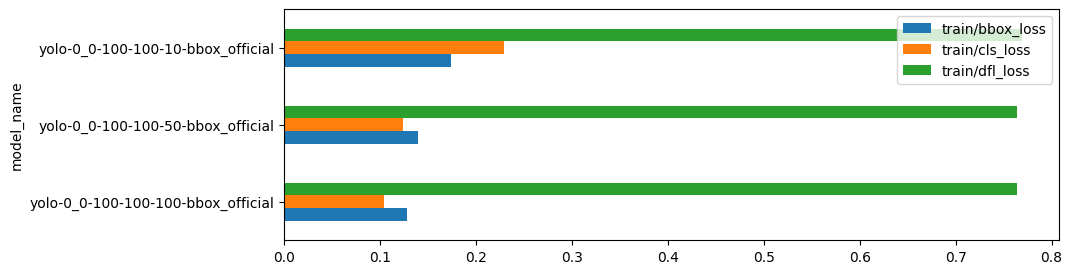

In [43]:
# loss das anotações perfeitas
df_filtered = df[(df['type'] == 'bbox_official')]
df_filtered = df_filtered.sort_values('train/bbox_loss', ascending=True)
df_filtered[get_loss].plot.barh(figsize=(10,3))

<Axes: ylabel='model_name'>

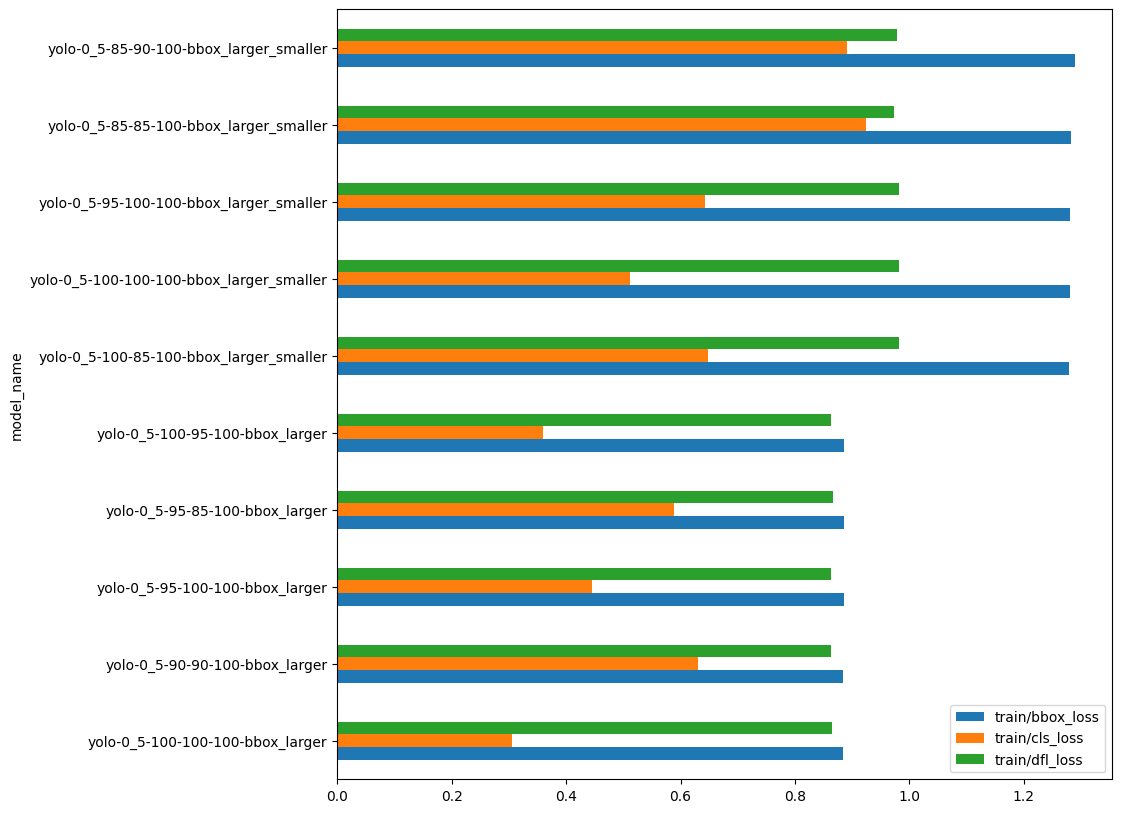

In [44]:
# 5 piores e 5 melhores bbox_loss - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['size_dataset'] == 100)]
df_filtered = pd.concat([df_filtered.sort_values('train/bbox_loss', ascending=True)[:5], df_filtered.sort_values('train/bbox_loss', ascending=True)[-5:]])
df_filtered[get_loss].plot.barh(figsize=(10,10))

In [45]:
# Anotações corretas com margem de 0_5 - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 100) & (df['all_class'] == 100) & (df['size_dataset'] == 100)]
df_filtered[get_tabela].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.999870,1.000000,0.994950,0.802250,0.999376,0.999523,0.999853,0.999688,0.632392,0.850430,0.795129
bbox_larger_smaller,0.971430,0.968930,0.983390,0.625630,0.981680,0.982070,0.999596,0.990756,0.980560,0.679293,0.973877
bbox_smaller,0.984690,0.980920,0.988880,0.724690,0.984888,0.989254,0.995539,0.992386,0.583160,0.776214,0.771173


<Axes: ylabel='model_name'>

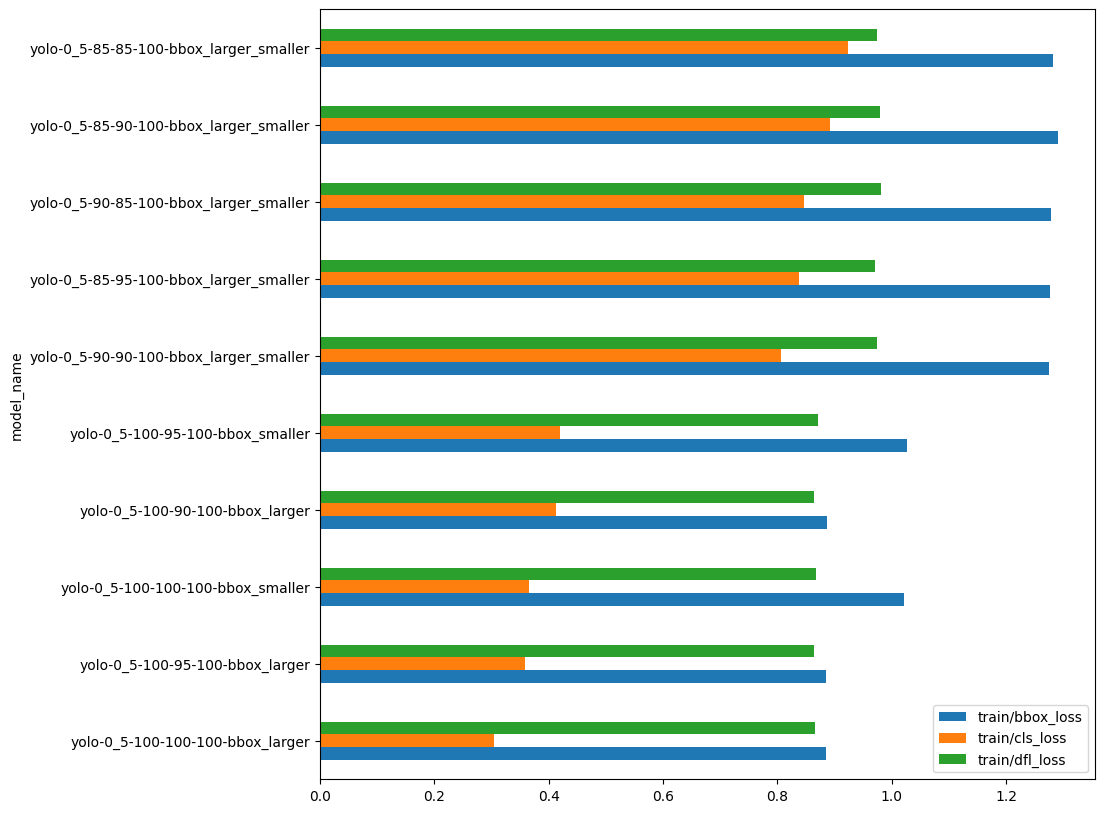

In [46]:
# 5 piores e 5 melhores cls_loss - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['size_dataset'] == 100)]
df_filtered = pd.concat([df_filtered.sort_values('train/cls_loss', ascending=True)[:5], df_filtered.sort_values('train/cls_loss', ascending=True)[-5:]])
df_filtered[get_loss].plot.barh(figsize=(10,10))

<Axes: ylabel='model_name'>

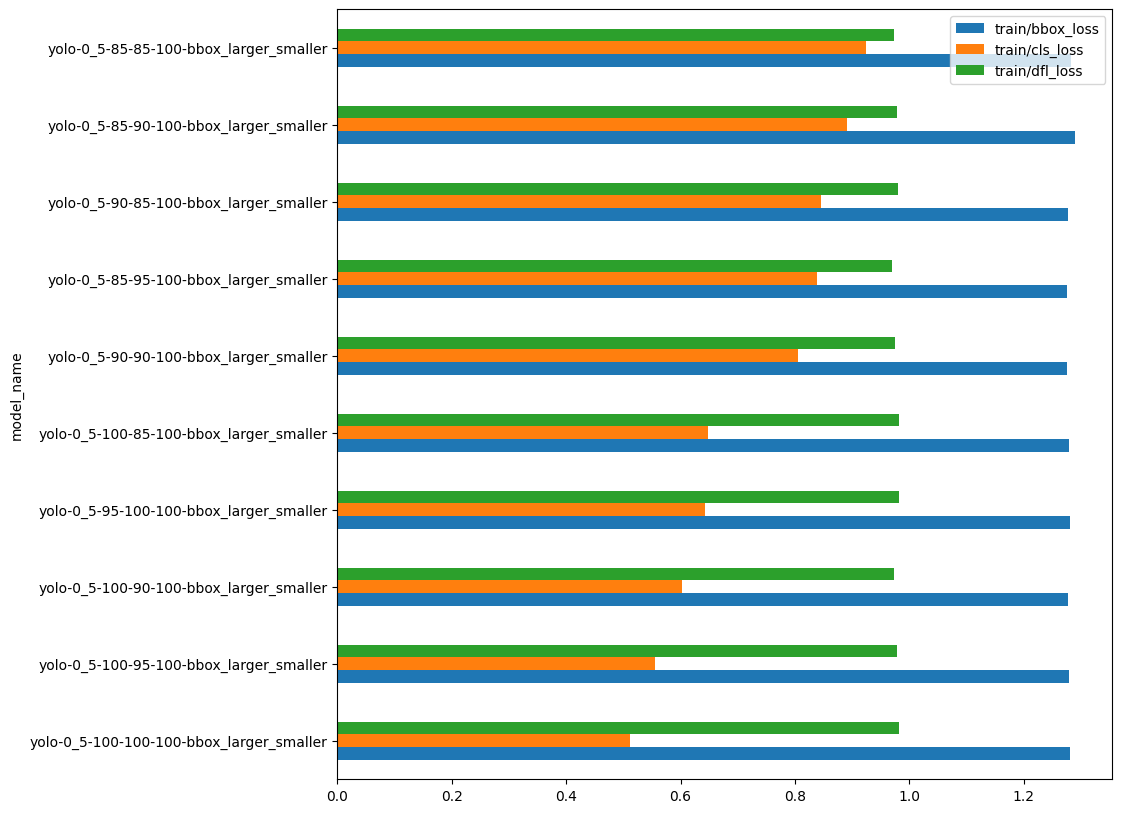

In [47]:
# 5 piores e 5 melhores bbox_loss somente larger_smaller - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[(df['type'] == 'bbox_larger_smaller') & (df['margin'] == '0_5') & (df['size_dataset'] == 100)]
df_filtered = pd.concat([df_filtered.sort_values('train/cls_loss', ascending=True)[:5], df_filtered.sort_values('train/cls_loss', ascending=True)[-5:]])
df_filtered[get_loss].plot.barh(figsize=(10,10))

In [48]:
# Anotações corretas com margem de 0_5 - 100% dos dados de treinamento (6000 imagens)
df_filtered = df[(df['margin'] == '0_5') & (df['right_class'] == 100) & (df['all_class'] == 100) & (df['size_dataset'] == 100)]
df_filtered[get_tabela].groupby('type').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
type,,,,,,,,,,,
bbox_larger,0.999870,1.000000,0.994950,0.802250,0.999376,0.999523,0.999853,0.999688,0.632392,0.850430,0.795129
bbox_larger_smaller,0.971430,0.968930,0.983390,0.625630,0.981680,0.982070,0.999596,0.990756,0.980560,0.679293,0.973877
bbox_smaller,0.984690,0.980920,0.988880,0.724690,0.984888,0.989254,0.995539,0.992386,0.583160,0.776214,0.771173


## Analisando tempo de treinamento
Adicionar mais dados de treinamento pode a primeiro momento parecer algo interessante já que estamos (em muitas vezes) aumentando a diversidade de cenários, consequentemente ajudando na generalização do modelo. Mas isso gera outras consequências como um tempo de treinamento maior e mais dados para serem anotados. Segue alguns pensamentos baseados nos resultados:

- O aumento do dataset não aumenta proporcionalmente o tempo de treinamento para dataset muito pequenos, mas para dataset grandes, sim -> comparando o tempo médio por época do dataset perfeitamente anotado entre os diferentes tamanhos de dataset, o crescimento do tempo entre 10% e 50% do dataset (5 vezes mais dados) ficou 3,3 vezes maior o tempo médio por época, comparando 10% com 100% do dataset (10 vezes mais dados) ficou 6,7 vezes maior o tempo médio por época, já comparando o 50% com 100% (2 vezes mais dados) ficou 2 vezes maior o tempo médio por época, ou seja, quanto menos dados, menor o impacto na diferença do tempo. Depois de passar muito tempo pensando, sinceramente não entendi porque o tempo não cresceu proporcional em todos os casos... não estou considerando algo relevante?
- Aumentar o dataset possue como consequências o aumento do tempo de treinamento e de anotação, e não é proporcional a melhora dos resultados do modelo -> deve ser analisado com muito cuidado até que ponto vale a pena adicionar mais dados, pois nem sempre irá melhorar significativamente os resultados. Neste caso se mostrou muito mais importante anotar 600 dados de treinamento muito bem anotados do que 3000 ou 6000 dados com anotações medianas. Isso também considerando que com 600 imagens já foi mais que suficiente para atender todos os cenários possível da nossa situação, ou seja, mais dados que isso só seriam necessários se a complexidade do ambiente fosse muito maiores e que nosso modelos não estivesse atingindo bons resultados (possivelmente até mesmo menas imagens para o nosso cenários já seriam suficientes);

**Em resumo:** Podemos assumir, para simplificar, que o aumento do dataset aumenta proporcionalmente o tempo de treinamento, mas não melhora proporcionalmente os resultados. É muito mais importante ter um dataset muito bem anotado do que quantidade, pois além de aumentar o tempo de treinamento, aumentar a quantidade de imagens para serem anotadas e se você (ou sua equipe) não tiver ânimo suficiente para anotar muito bem um dataset pequeno... imagina um grande! Lembrando que neste caso o nosso dataset cobriu todo o cenário e complexidade, caso contrário, sim, aumentar o dataset iria ajudar, mesmo com anotações medianas... mas talvez, não o suficiente quando anotações bem realizadas?

In [49]:
get_time = ['train/num_epochs', 'train/total_time', 'test/fscore']
get_tabela_time = ['size_dataset', 'train/mean_time_epoch', 'train/num_epochs', 'train/total_time']
get_tabela = ['size_dataset', 'val/precision', 'val/recall', 'val/mAP50', 'val/mAP50-95',
              'test/accuracy', 'test/precision', 'test/recall', 'test/fscore',
              'test/mAP50-95', 'test/mean_confidence', 'test/mean_IoU']

<Axes: ylabel='model_name'>

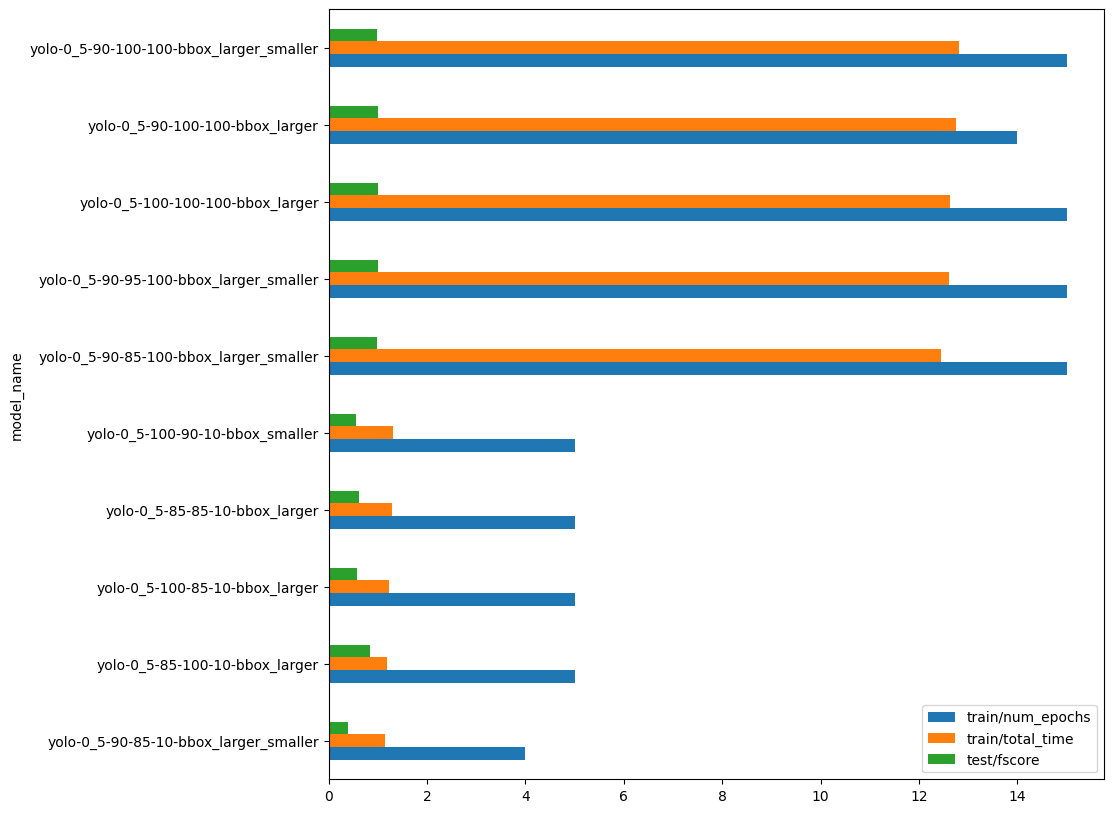

In [50]:
# 5 piores e 5 melhores cls_loss
df_filtered = df[(df['margin'] == '0_5')]
df_filtered = pd.concat([df_filtered.sort_values('train/total_time', ascending=True)[:5], df_filtered.sort_values('train/total_time', ascending=True)[-5:]])
df_filtered[get_time].plot.barh(figsize=(10,10))

In [51]:
# Anotações corretas com margem de 0_0 - sem problemas de anotação
df_filtered = df[(df['margin'] == '0_0') & (df['right_class'] == 100) & (df['all_class'] == 100)]
df_filtered[get_tabela_time].groupby('size_dataset').mean().style.background_gradient()

,train/mean_time_epoch,train/num_epochs,train/total_time
size_dataset,,,
10,0.124041,15.000000,1.860615
50,0.410193,15.000000,6.152889
100,0.836343,15.000000,12.545142


In [52]:
# Anotações corretas com margem de 0_0 - sem problemas de anotação
df_filtered = df[(df['margin'] == '0_0') & (df['right_class'] == 100) & (df['all_class'] == 100)]
df_filtered[get_tabela].groupby('size_dataset').mean().style.background_gradient()

,val/precision,val/recall,val/mAP50,val/mAP50-95,test/accuracy,test/precision,test/recall,test/fscore,test/mAP50-95,test/mean_confidence,test/mean_IoU
size_dataset,,,,,,,,,,,
10,0.999940,0.999790,0.995000,0.993510,0.999670,0.999725,0.999945,0.999835,0.992573,0.981530,0.983552
50,0.999840,1.000000,0.995000,0.994900,0.999853,0.999871,0.999982,0.999927,0.994498,0.977077,0.988883
100,0.999960,1.000000,0.995000,0.994970,0.999816,0.999853,0.999963,0.999908,0.994527,0.976389,0.990647
